# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from IPython.display import display
import operator
pd.set_option('display.max_rows', 100)

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [48]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

#### Demographic data (Azdias)

In [49]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

# show structure
print('structure of demographic data: ', azdias.shape)

structure of demographic data:  (891221, 85)


In [50]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [51]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

#### Feature summary (Feat_info)

In [52]:
# show structure
print('structure of feature summary: ', feat_info.shape)

structure of feature summary:  (85, 4)


In [53]:
# show dataset
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [54]:
# create copy of original datasets for data cleaning
azdias_clean = azdias.copy()
feat_info_clean = feat_info.copy()

In [55]:
# get number of missing values as reference
print('number of missing values in original dataset: ', azdias_clean.isnull().sum().sum())

number of missing values in original dataset:  4896838


In [56]:
# Identify missing or unknown data values and convert them to NaNs.

# 1st: strip brackets ([...])  from strings in 'missing_or_unknown'-column

feat_info_clean.missing_or_unknown = feat_info_clean.missing_or_unknown.str.strip('[').str.strip(']')

# 2nd: loop through each column of the dataset
for col in range(azdias_clean.shape[1]):
    # get column name
    column_name = azdias_clean.columns[col] 
    # get values indicating missing or unknown data for each column and save as list of strings
    list_of_na_vals = feat_info_clean.iloc[col,3].split(',')
    # check whether there are any values within the list (empty list in indicated with [''])
    if list_of_na_vals==['']:
        continue
    else:
        # 3rd: loop through list of NA values and replace the values indicating missing or unknown data with np.nan
        for NaN_code in list_of_na_vals:
            # differ between values savd as string objects or as numbers to extract the right code for NaNs
            if azdias_clean[column_name].dtype =='object':
                azdias_clean.loc[azdias_clean[column_name]==NaN_code,column_name]=np.nan 
            else:   
                NaN_code=int(NaN_code)
                azdias_clean.loc[azdias_clean[column_name]==NaN_code,column_name]=np.nan

In [57]:
# get new number of missing values (should be higher since we added the coded NaNs)
print('number of missing values in original dataset: ', azdias_clean.isnull().sum().sum())
print('number of new NaN values: ', azdias_clean.isnull().sum().sum() - azdias.isnull().sum().sum() )
print('total number of data in original dataset: ', azdias_clean.size)
print('proportion of missing data in original dataset: {:.2f}%'.format(azdias_clean.isnull().sum().sum()/azdias_clean.size*100))

number of missing values in original dataset:  8373929
number of new NaN values:  3477091
total number of data in original dataset:  75753785
proportion of missing data in original dataset: 11.05%


So, we get 3,477,091 new missing or unknown values, which result in a total amount of missing values within the dataset of 8,373,929. This seems to be a lot of data, however it is only around 11% of the total amount of data.

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [58]:
# Perform an assessment of how much missing data there is in each column of the dataset.

# calculate and present the missing data for each column
missing_data_cols = azdias_clean.isnull().sum()
missing_data_cols

AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
ANREDE_KZ                     0
CJT_GESAMTTYP              4854
FINANZ_MINIMALIST             0
FINANZ_SPARER                 0
FINANZ_VORSORGER              0
FINANZ_ANLEGER                0
FINANZ_UNAUFFAELLIGER         0
FINANZ_HAUSBAUER              0
FINANZTYP                     0
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
GREEN_AVANTGARDE              0
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SEMIO_SOZ                     0
SEMIO_FAM                     0
SEMIO_REL                     0
SEMIO_MAT                     0
SEMIO_VERT                    0
SEMIO_LUST                    0
SEMIO_ERL                     0
SEMIO_KU

There is a huge variety within the amount of missing data for each column. Thus, we have to find the columns with the highest percentage of missing data. Columns in which no data is missing or unknown can obviously stay in the dataset.

In the next cells, we want to investigate the the patterns of missing data in the remaining columns.

In [59]:
# Investigate patterns in the amount of missing data in each column.

# calculate the percentage of missing data for each column
missing_data_cols_percentage = missing_data_cols/azdias_clean.shape[0] * 100

# sort the percentages from top to bottom
missing_data_cols_percentage.sort_values(inplace=True)


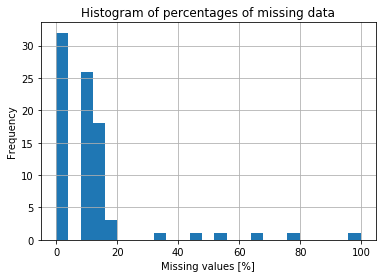

In [60]:
# Plot distribution of missing data columns
plt.hist(missing_data_cols_percentage, bins = 25)
plt.xlabel('Missing values [%]')
plt.ylabel('Frequency')
plt.title('Histogram of percentages of missing data')
plt.grid(True)
plt.show()

In [61]:
# show information of the distribution
missing_data_cols_percentage.describe()

count    85.000000
mean     11.054139
std      16.449815
min       0.000000
25%       0.000000
50%      10.451729
75%      13.073637
max      99.757636
dtype: float64

Most of the columns have a percentage of missing data of around 11% and is located in the range between 0% and 20%. However, there are also some outliers above 20%. Some columns also have missing data rates higher than 90% which can't be used in any term for further work.

Thus, let's take look at which columns have the highest percentage of missing values to remove them from the dataset. 

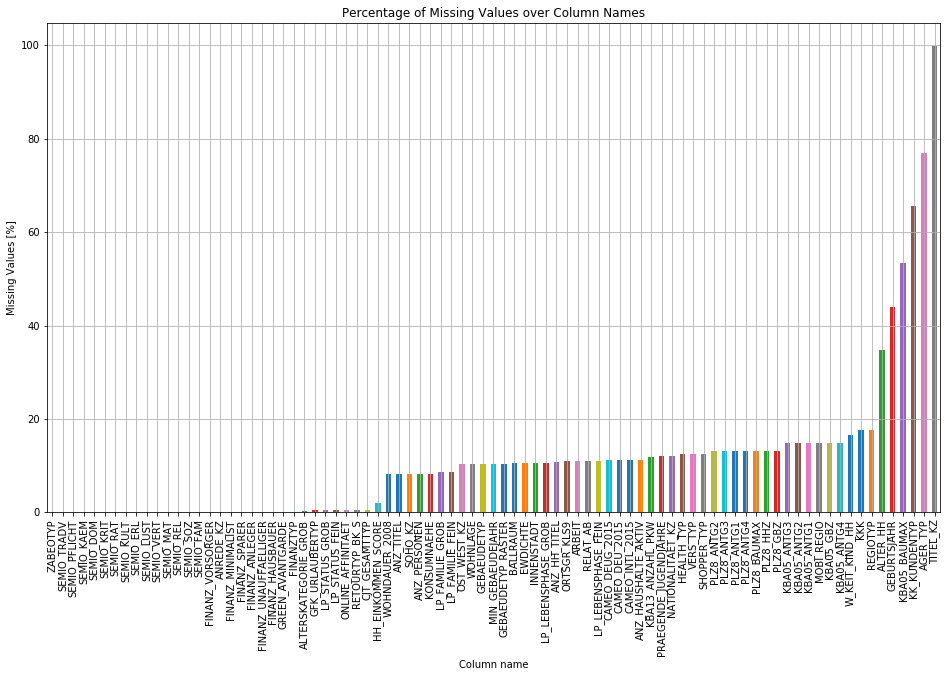

In [62]:
missing_data_cols_percentage.plot.bar(figsize=(16,9))
plt.xlabel('Column name')
plt.ylabel('Missing Values [%]')
plt.title('Percentage of Missing Values over Column Names')
plt.grid(True)
plt.show();

The majority of the columns have a missing data rate between 0% and 20%. Thus, we want to remove the outlier columns with proportions above 20%, which seem to have exorbitant high percentages of missing values.  

Here, these 6 columns are:

In [63]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# find column names with missing value rates of 20% and remove these columns from the dataset
for col in azdias_clean.columns:
    if missing_data_cols_percentage[col] > 20:
        azdias_clean.drop(col, axis = 1, inplace=True)
        # additionally drop the row in feat_info_clean, since this feature is not used anymore
        feat_info_clean = feat_info_clean[feat_info_clean["attribute"]!=col]
        print('Removed: ', col)

Removed:  AGER_TYP
Removed:  GEBURTSJAHR
Removed:  TITEL_KZ
Removed:  ALTER_HH
Removed:  KK_KUNDENTYP
Removed:  KBA05_BAUMAX


#### Discussion 1.1.2: Assess Missing Data in Each Column

Nearly every column has missing values only a quite small proportion of columns has no values declared as missing or unknown. We found out, that most of the columns have a rate of missing values lower than 20% (see figure above). However, columns with a percentage of missing values larger than 20% do not follow the distribution of the other columns. These ones show a very large missing value proportion from 30% up to 99.75%. The usage of these features in further clustering methods seems to be very impractical, since they do not affect the majority of observations.

Thus, we removed the columns named above in the AZDIAS dataset and its corresponding row in the feat_info DataFrame.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [64]:
# How much data is missing in each row of the dataset?

# calculate and present the missing data for each column
missing_data_rows = azdias_clean.isnull().sum(axis = 1)

# calculate the percentage of missing data for each column
missing_data_rows_percentage = missing_data_rows/azdias_clean.shape[1] * 100

# sort the percentages from top to bottom
missing_data_rows_percentage.sort_values(inplace=True)


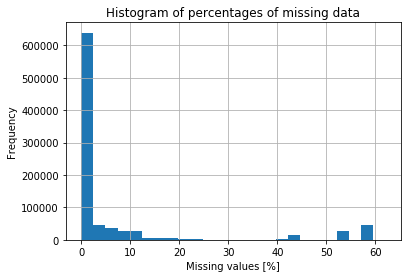

In [65]:
# Plot distribution of missing data rows
plt.hist(missing_data_rows_percentage, bins = 25)
plt.xlabel('Missing values [%]')
plt.ylabel('Frequency')
plt.title('Histogram of percentages of missing data')
plt.grid(True)
plt.show()

We can see that most of the rows have a rate of 0% of missing values. Thus, we want to take a closer look and exclude these rows in the histogram.

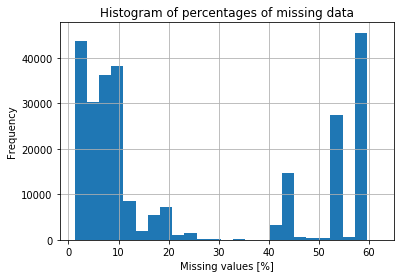

In [66]:
# Plot distribution of missing data rows (exclude rows with no missing values)
plt.hist(missing_data_rows_percentage[missing_data_rows_percentage > 0], bins = 25)
plt.xlabel('Missing values [%]')
plt.ylabel('Frequency')
plt.title('Histogram of percentages of missing data')
plt.grid(True)
plt.show()

The rows with at least one missing value is distributed as shown above. The distribution seems to be bimodal because there is an accumulation of rows with a missing value rate of less than 10% and a cluster of rows with a rate higher than 40%.
Since we have to take the rows with a missing value rate of 0% into account we split the dataset at a threshold of 4 missing values.

In [67]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_vals_threshold = 4
low_missing_vals_rows = azdias_clean[azdias_clean.isnull().sum(axis=1) < missing_vals_threshold].reset_index(drop = True)
high_missing_vals_rows = azdias_clean[azdias_clean.isnull().sum(axis=1) >= missing_vals_threshold].reset_index(drop = True)

In [68]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def plot_distribution_compare(cols, nums):
    '''
    Function to randomly create 'nums' plots of feature distributions for the groups of rows 
    with low and high missing values.
    
    Input: cols: column names
           nums: number of plotted distributions
    '''
    # prepare subplots
    fig, axs = plt.subplots(nums,2, figsize = (15,25), facecolor = 'w', edgecolor = 'k')
    fig.subplots_adjust(hspace = 1, wspace = .2)
    axs = axs.ravel()
    rand_cols = [cols[random.randrange(len(cols))] for item in range(nums)]
    # loop through randomly picked columns and countplot the distribution for each group
    n = 0
    for i in rand_cols:
        sns.countplot(low_missing_vals_rows[i], ax=axs[n*2])
        axs[n*2].set_title('low missing rate')
        sns.countplot(high_missing_vals_rows[i], ax=axs[n*2+1])
        axs[n*2+1].set_title('high missing rate')
        n += 1

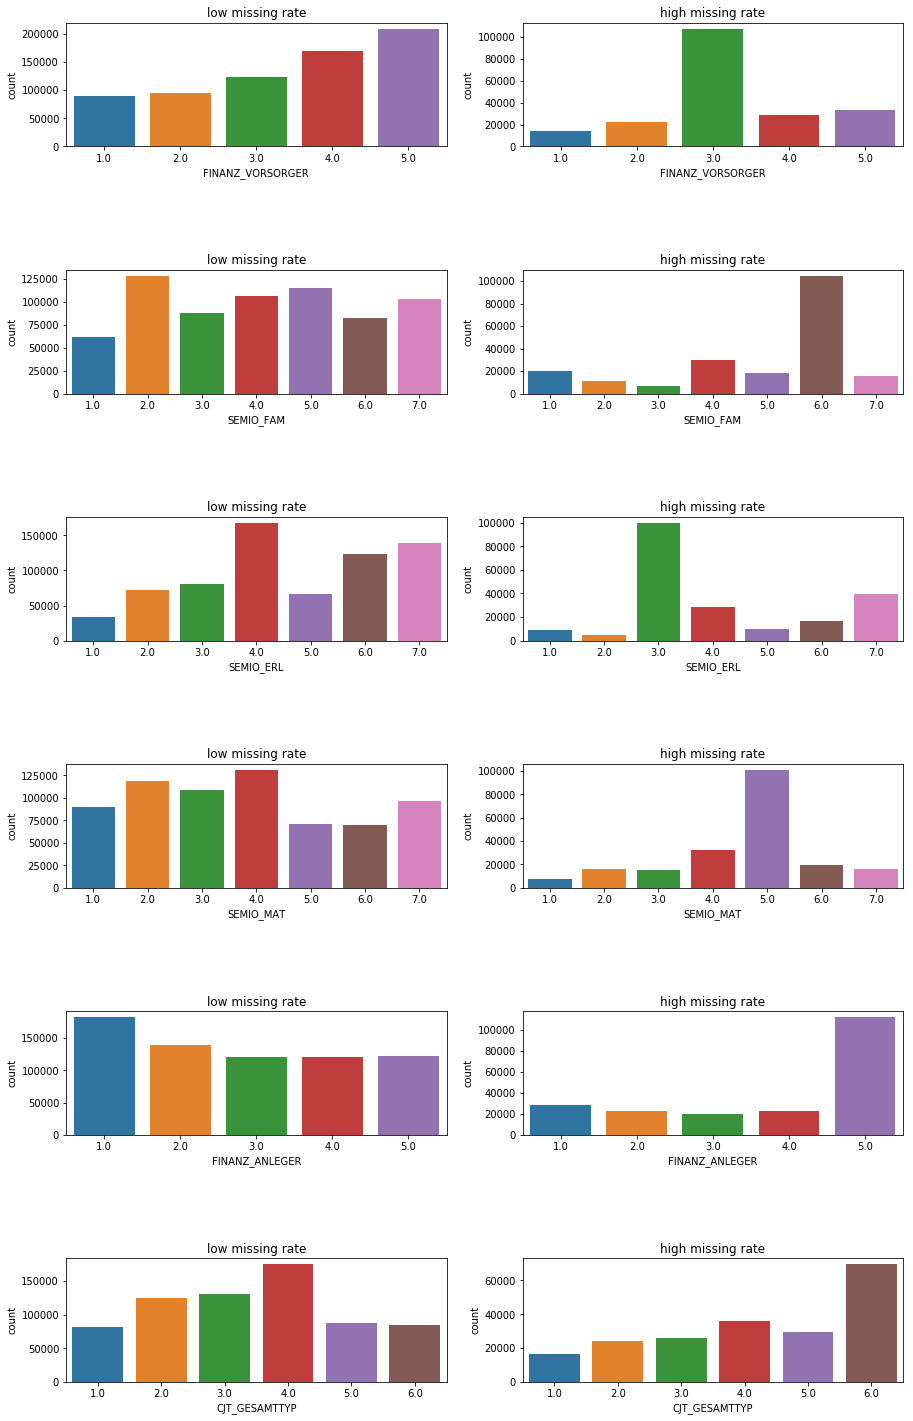

In [69]:
# call defined plotting function
column_names = azdias_clean.columns
num_cols_to_plot = 6

plot_distribution_compare(column_names, num_cols_to_plot)

#### Discussion 1.1.3: Assess Missing Data in Each Row

Comparing the distributions of random features for rows with a low rate of missing values (less than 4 missing values) and with a high rate of these values, we can observe that some distributions greatly differ. However, some distributions show the same pattern but with a different amount of counted values for each feature.

Large differences in the dataset will cause generalizations within the clustering process or within the Principal Component Analysis (PCA) of some features. Thus, the result will become less useful and practical according to target special customers and customer characteristics.

As a consequence, I we can either drop all rows with at least one missing value or comprehensibly fill the missing values in the first group of the dataset (the group with a low missing value rate) with realistic data.

In [70]:
print('Number of rows with no missing values: ', len(azdias_clean[azdias_clean.isnull().sum(axis=1) == 0]))
print('Number of rows with low rate of missing values: ', len(low_missing_vals_rows))
print('Dropping all rows with NAs in the "low missing value rate"-group will cause a loss of {:.2f}% of the values.'.format(
    (len(low_missing_vals_rows)-len(azdias_clean[azdias_clean.isnull().sum(axis=1) == 0]))/len(low_missing_vals_rows)*100))

Number of rows with no missing values:  623209
Number of rows with low rate of missing values:  684502
Dropping all rows with NAs in the "low missing value rate"-group will cause a loss of 8.95% of the values.


As shown in the cell above, we only lose a proportion of around 9% of the dataset within the group with low missing value rate in case we drop all rows with at least one missing value. By taking into consideration that an amount of 623,209 observations can be used for further works without adjusting or manipulating the data, this approach seems acceptable.

In [71]:
# Drop rows with NA values and show shape of remaining dataset
azdias_clean.dropna(inplace=True)
azdias_clean.shape

(623209, 79)

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [72]:
# How many features are there of each data type?
feat_info_clean.type.value_counts()


ordinal        49
categorical    18
mixed           6
numeric         6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [73]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# create a dataframe containing all categorical features, their unique categories and the correspoding dtype
categorical_features_attribute = []
categorical_features_number = []
categorical_features_dtype = []
print("Categorical Features:")
for col in azdias_clean.columns:
    if feat_info_clean[feat_info_clean["attribute"]==col].type.values[0]=='categorical':
        categorical_features_attribute.append(col)
        categorical_features_number.append(len(azdias_clean[col].unique()))
        categorical_features_dtype.append(azdias_clean[col].dtype)
        print("Column: ",col, "\t unique categories: ", len(azdias_clean[col].unique()), "\t dtype: ", azdias_clean[col].dtype)

df_categorical_features = pd.DataFrame(index=categorical_features_attribute,
                                       columns=['number','dtype'])
df_categorical_features.number = categorical_features_number
df_categorical_features.dtype = categorical_features_dtype
df_categorical_features

Categorical Features:
Column:  ANREDE_KZ 	 unique categories:  2 	 dtype:  float64
Column:  CJT_GESAMTTYP 	 unique categories:  6 	 dtype:  float64
Column:  FINANZTYP 	 unique categories:  6 	 dtype:  float64
Column:  GFK_URLAUBERTYP 	 unique categories:  12 	 dtype:  float64
Column:  GREEN_AVANTGARDE 	 unique categories:  2 	 dtype:  int64
Column:  LP_FAMILIE_FEIN 	 unique categories:  11 	 dtype:  float64
Column:  LP_FAMILIE_GROB 	 unique categories:  5 	 dtype:  float64
Column:  LP_STATUS_FEIN 	 unique categories:  10 	 dtype:  float64
Column:  LP_STATUS_GROB 	 unique categories:  5 	 dtype:  float64
Column:  NATIONALITAET_KZ 	 unique categories:  3 	 dtype:  float64
Column:  SHOPPER_TYP 	 unique categories:  4 	 dtype:  float64
Column:  SOHO_KZ 	 unique categories:  2 	 dtype:  float64
Column:  VERS_TYP 	 unique categories:  2 	 dtype:  float64
Column:  ZABEOTYP 	 unique categories:  6 	 dtype:  float64
Column:  GEBAEUDETYP 	 unique categories:  4 	 dtype:  float64
Column:  OST_WES

,number,dtype
ANREDE_KZ,2,float64
CJT_GESAMTTYP,6,float64
FINANZTYP,6,float64
GFK_URLAUBERTYP,12,float64
GREEN_AVANTGARDE,2,int64
LP_FAMILIE_FEIN,11,float64
LP_FAMILIE_GROB,5,float64
LP_STATUS_FEIN,10,float64
LP_STATUS_GROB,5,float64
NATIONALITAET_KZ,3,float64


In [74]:
binary_features = list(df_categorical_features[df_categorical_features["number"]==2].index.values)
non_binary_features = list(df_categorical_features[df_categorical_features["number"]!=2].index.values)
print("number of binary categories: ", len(binary_features))
print("number of non-binary categories: ", len(non_binary_features))
binary_features

number of binary categories:  5
number of non-binary categories:  13


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [75]:
non_binary_features

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

There is one binary feature with dtype 'object'. E.g., the information is not coded as 0 and 1, but with other values showing a binary relationship. Thus, we have to re-encode this information using 0 and 1.

In [76]:
# Find binary features with type 'object'
binary_object_feature = list(df_categorical_features[(df_categorical_features["number"]==2) & (df_categorical_features["dtype"]=="object")].index.values)
binary_object_feature

['OST_WEST_KZ']

In [77]:
# re-encode binary object features (OST_WEST_KZ)
re_encode = {'O':0, 'W':1}
azdias_clean.replace({binary_object_feature[0] : re_encode}, inplace=True)

In [78]:
# test re-encoded column
azdias_clean.OST_WEST_KZ.value_counts()

1    490879
0    132330
Name: OST_WEST_KZ, dtype: int64

Investigating the binary and non-binary features, we can see that most of the categorical features have multiple levels. Dropping them will cause a huge loss of data. Additionally, these categorical features contain a lot of information according to shopping and spending habits that are necessary for further customer clustering steps (e.g. GFK_URLAUBERTYP - vacation habits).

Thus, we have to put the most descriptive of these features into dummy variables. For consumption habits the most descriptive features are:
- GFK_URLAUBERTYP
- LP_FAMILIE_GROB
- CJT_GESAMTTYP
- NATIONALITAET_KZ

The feature CJT_GESAMTTYP covers a lot of information, that are also contained in other variables like SHOPPER_TYP. Also the information contained within the type FINANZTYP can be described by ordinal variables FINANZ_XXX. Additionally, LP_STATUS_GROB and LP_STATUS_FEIN as well as CAMEO_DEU_2015 and CAMEO_DEUG_2015 are dropped since their information are included within FINANZ_TYP in a more compact form. I would like to include the family status in our further considerations since it might be useful. Therefor, I decided to drop LP_FAMILIE_FEIN and keep LP_FAMILIE_GROB since the first one is way too complex. Furthermore, the nationality of the individual is considered by keeping the feature NATIONALITAET_KZ The feature ZABEOTYP, which describes the energy consumption technology, is also not taken into account, because the behaviour towards environmental sustainability can be inferred from the binary feature GREEN_AVANTGARDE.
The same reasoning applies for GABAEUDETYP, which also can be dropped.


In [79]:
# create dictionaries with an assignment of categories and corresponding information for each of the features
# which have to be transformed into dummy variables
GFK_URLAUBERTYP_dict = {1: "Event_travelers",
                        2: "Family_oriented_vacationists",
                        3: "Winter_sportspeople",
                        4: "Culture_lovers",
                        5: "Nature_fans",
                        6: "Hiker",
                        7: "Golden_ager",
                        8: "Homeland_connected_vacationists",
                        9: "Package_tour_travelers",
                        10: "Connoisseurs",
                        11: "Active_families",
                        12: "Without_vacation"}

LP_FAMILIE_GROB_dict = {1: "single",
                        2: "couple",
                        3: "single_parent",
                        4: "family",
                        5: "multiperson_household"}

CJT_GESAMTTYP_dict = {1: "Advertising_and_Consumptionminimalist",
                      2: "Advertising_and_Consumptiontraditionalist",
                      3: "advertisinginterested_Store_shopper",
                      4: "advertisinginterested_Online_shopper",
                      5: "Advertising_and_Cross_Channel_Enthusiast",
                      6: "Advertising_Enthusiast_with_restricted_Cross_Channel_Behaviour"}

NATIONALITAET_KZ_dict = {1: "German_sounding",
                         2: "foreign_sounding",
                         3: "assimilated_names"}


In [80]:
# defining the removal of non-binary columns 
keep_columns = ['GFK_URLAUBERTYP', 'LP_FAMILIE_GROB','CJT_GESAMTTYP','NATIONALITAET_KZ']
delete_columns = [i for i in non_binary_features if i not in keep_columns]
delete_columns

['FINANZTYP',
 'LP_FAMILIE_FEIN',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [81]:
# delete non-binary columns with exception of the features named above
azdias_clean.drop(delete_columns,axis=1,inplace=True)

In [82]:
azdias_clean.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE', 'HEALTH_TYP',
       'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB', 'LP_FAMILIE_GROB',
       'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE', 'RETOURTYP_BK_S',
       'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT',
       'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT',
       'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ',
       'VERS_TYP', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'W_KEIT_KIND_HH', 'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV',
       'ANZ_HH_TITEL', 'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ',
       'WOHNLAGE', 'CAMEO_INTL_2015', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBA

In [83]:
# Re-encode categorical variable(s) to be kept in the analysis.

# divide the dataset in non_binary categorical features (azdias_clean_cat) and 
# non-categorical as well as binary categorical data (azdias_clean_noncat)
azdias_clean_cat = azdias_clean[keep_columns]
azdias_clean_noncat = azdias_clean.drop(keep_columns, axis=1)

# create new column names for encoded category features
cat_columns = []
for col in keep_columns:
    if col == "GFK_URLAUBERTYP":
        dictionary = GFK_URLAUBERTYP_dict
    elif col == "LP_FAMILIE_GROB":
        dictionary = LP_FAMILIE_GROB_dict
    elif col == "CJT_GESAMTTYP":
        dictionary = CJT_GESAMTTYP_dict
    elif col == "NATIONALITAET_KZ":
        dictionary = NATIONALITAET_KZ_dict
    for i in range(1,len(dictionary)+1):
        cat_columns.append(col + '_' + dictionary[i])
        
cat_columns

['GFK_URLAUBERTYP_Event_travelers',
 'GFK_URLAUBERTYP_Family_oriented_vacationists',
 'GFK_URLAUBERTYP_Winter_sportspeople',
 'GFK_URLAUBERTYP_Culture_lovers',
 'GFK_URLAUBERTYP_Nature_fans',
 'GFK_URLAUBERTYP_Hiker',
 'GFK_URLAUBERTYP_Golden_ager',
 'GFK_URLAUBERTYP_Homeland_connected_vacationists',
 'GFK_URLAUBERTYP_Package_tour_travelers',
 'GFK_URLAUBERTYP_Connoisseurs',
 'GFK_URLAUBERTYP_Active_families',
 'GFK_URLAUBERTYP_Without_vacation',
 'LP_FAMILIE_GROB_single',
 'LP_FAMILIE_GROB_couple',
 'LP_FAMILIE_GROB_single_parent',
 'LP_FAMILIE_GROB_family',
 'LP_FAMILIE_GROB_multiperson_household',
 'CJT_GESAMTTYP_Advertising_and_Consumptionminimalist',
 'CJT_GESAMTTYP_Advertising_and_Consumptiontraditionalist',
 'CJT_GESAMTTYP_advertisinginterested_Store_shopper',
 'CJT_GESAMTTYP_advertisinginterested_Online_shopper',
 'CJT_GESAMTTYP_Advertising_and_Cross_Channel_Enthusiast',
 'CJT_GESAMTTYP_Advertising_Enthusiast_with_restricted_Cross_Channel_Behaviour',
 'NATIONALITAET_KZ_German_s

In [84]:
# implementation of one-hot encoding of the categorical subset
onehotencoder = OneHotEncoder(handle_unknown='ignore')
azdias_clean_cat_enc = onehotencoder.fit_transform(azdias_clean_cat).toarray()

In [85]:
# combine datasets again
azdias_clean_encoded = azdias_clean_noncat.join(
    pd.DataFrame(azdias_clean_cat_enc,azdias_clean_noncat.index, columns = cat_columns))

# display shape of encoded dataset
azdias_clean_encoded.shape                                                

(623209, 92)

In [86]:
azdias_clean_encoded.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,LP_FAMILIE_GROB_multiperson_household,CJT_GESAMTTYP_Advertising_and_Consumptionminimalist,CJT_GESAMTTYP_Advertising_and_Consumptiontraditionalist,CJT_GESAMTTYP_advertisinginterested_Store_shopper,CJT_GESAMTTYP_advertisinginterested_Online_shopper,CJT_GESAMTTYP_Advertising_and_Cross_Channel_Enthusiast,CJT_GESAMTTYP_Advertising_Enthusiast_with_restricted_Cross_Channel_Behaviour,NATIONALITAET_KZ_German_sounding,NATIONALITAET_KZ_foreign_sounding,NATIONALITAET_KZ_assimilated_names
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
7,1.0,1.0,3.0,3.0,4.0,1.0,3.0,2.0,0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,3.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,1,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9,3.0,2.0,2.0,4.0,2.0,3.0,5.0,4.0,1,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
10,3.0,2.0,2.0,2.0,5.0,3.0,1.0,5.0,0,2.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19,3.0,1.0,5.0,2.0,3.0,1.0,3.0,1.0,1,3.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Discussion 1.2.1: Re-Encode Categorical Features

We had 18 categorical features. Five of them were binary and 13 non-binary. It is hard to practically use categorical data encoding information into several incoherent values, expecially with a different amount of categories.

Therefor, we want to encode the dataset to transform non-binary categorical features into binary ones. Categories that were already binary were kept. Here, we only had to convert the dtype of feature OST_WEST_KZ, to get practical integer values.

Within the encoding of non-binary categories, we dropped 9 of 13 columns, which information were also covered by other features. The reasoning can be found above.
After that, we applied OneHotEncoding on the remaining 4 non-binary categorical features, to obtain a new column for each category and binary values of 0 and 1. We also adjusted the columns to assign the data in more appropriate way in the later tasks.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

###### Step 1.2.2.1 PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [87]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# define the values of PRAEGENDEJUGENDJAHRE that are assigned to Mainstream and Avantgarde
Mainstream_values = azdias_clean_encoded.PRAEGENDE_JUGENDJAHRE.unique()[azdias_clean_encoded.PRAEGENDE_JUGENDJAHRE.unique() % 2 == 1]
Avantgarde_values = azdias_clean_encoded.PRAEGENDE_JUGENDJAHRE.unique()[azdias_clean_encoded.PRAEGENDE_JUGENDJAHRE.unique() % 2 == 0]

# create a MOVEMENT column and put a 0 for Mainstream and a 1 for Avantgarde
azdias_clean_encoded['MOVEMENT'] = np.where(azdias_clean_encoded.PRAEGENDE_JUGENDJAHRE.isin(Mainstream_values), 0, 1)
azdias_clean_encoded[["MOVEMENT","PRAEGENDE_JUGENDJAHRE"]].head(10)

,MOVEMENT,PRAEGENDE_JUGENDJAHRE
1,1,14.0
2,0,15.0
4,1,8.0
5,0,3.0
6,1,10.0
7,1,8.0
8,0,11.0
9,0,15.0
10,0,3.0
19,0,9.0


In [88]:
# create an interval-type variable for decade of PRAEGENDE_JUGENDJAHRE
# define a dictionary with assignments of values of PRAEGENDE_JUGENDJAHRE and the corresponding decade
decade_dict = {1.0: 1940, 2.0: 1940, 3.0: 1950, 4.0: 1950, 5.0: 1960, 6.0: 1960, 7.0: 1960, 8.0: 1970, 9.0: 1970, 
               10.0: 1980, 11.0: 1980, 12.0: 1980, 13.0: 1980, 14.0: 1990, 15.0: 1990}
azdias_clean_encoded.replace({"PRAEGENDE_JUGENDJAHRE" : decade_dict}, inplace=True)
# convert from float to integer
azdias_clean_encoded.PRAEGENDE_JUGENDJAHRE = azdias_clean_encoded.PRAEGENDE_JUGENDJAHRE.astype(int)
# rename column
azdias_clean_encoded.rename(index=str, columns={"PRAEGENDE_JUGENDJAHRE" : "DECADE"}, inplace=True)

In [89]:
# test by checking the unique values of PRAEGENDE_JUGENDJAHRE
azdias_clean_encoded.DECADE.unique()

array([1990, 1970, 1950, 1980, 1960, 1940], dtype=int64)

##### Step 1.2.2.2 CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

The feature CAMEO_INTL_2015 consists of codes for the wealth and the life stage of one individual. The first digit represents the level of wealth (1-5 : wealthy - poor) and the second one represents the level of life stage (1-5 : singles - elders in retirement).

Therefor, we split the value as a string variable into these two digits. After that, we create the new columns (WEALTH and LIFE_STAGE) and put the values in accordance with these digits.

In [90]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
# WEALTH: convert value in column into string and read the first digit - save as integer in column WEALTH
azdias_clean_encoded["WEALTH"] = azdias_clean_encoded.CAMEO_INTL_2015.astype(str).str[0].astype(int)

# LIFE_STAGE: convert value in column into string and read the second digit - save as integer in column LIFE_STAGE
azdias_clean_encoded["LIFE_STAGE"] = azdias_clean_encoded.CAMEO_INTL_2015.astype(str).str[1].astype(int)

# test by showing sample of subset
azdias_clean_encoded[["CAMEO_INTL_2015", "WEALTH", "LIFE_STAGE"]].head(10)


,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
1,51,5,1
2,24,2,4
4,43,4,3
5,54,5,4
6,22,2,2
7,14,1,4
8,13,1,3
9,15,1,5
10,51,5,1
19,34,3,4


In [91]:
# drop CAMEO_INTL_2015 column after succesful test
azdias_clean_encoded.drop("CAMEO_INTL_2015", axis=1, inplace=True)

###### Step 1.2.2.3 Other 'mixed' features

In [92]:
# investigate other variables typed as 'mixed'
feat_info_clean[feat_info_clean["type"]=='mixed']

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,0
16,LP_LEBENSPHASE_GROB,person,mixed,0
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"-1,0"
56,WOHNLAGE,building,mixed,-1
59,CAMEO_INTL_2015,microcell_rr4,mixed,"-1,XX"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"-1,0"


After encoding and renaming PRAEGENDE_JUGENDJAHRE into integer values and dropping CAMEO_INTL_2015, the dataset contains 4 further mixed features. These are:
- LP_LEBENSPHASE_FEIN: contains life stage and income data, which is already covered by features like WEALTH and LIFE_STAGE, thus we can drop this column.

- LP_LEBENSPHASE_GROB: same as LP_LEBENSPHASE_FEIN on rough scale. Drop!

- WOHNLAGE: contains information on neighborhood and living standards. Most of the information are already covered by variable BALLRAUM, which shows the distance to nearest urban center. Thus, I decided to drop this column.

- PLZ8_BAUMAX: similar to WOHNLAGE, but specified on the region of PLZ8 (Postleitzahl 8XXXX - a regional code in Germany). Thus, we can drop this feature, too.


In [93]:
# drop mixed columns
azdias_clean_encoded.drop(["LP_LEBENSPHASE_FEIN", "LP_LEBENSPHASE_GROB", "WOHNLAGE", "PLZ8_BAUMAX"], axis=1, inplace=True)

In [94]:
azdias_clean_encoded.head(10)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CJT_GESAMTTYP_advertisinginterested_Store_shopper,CJT_GESAMTTYP_advertisinginterested_Online_shopper,CJT_GESAMTTYP_Advertising_and_Cross_Channel_Enthusiast,CJT_GESAMTTYP_Advertising_Enthusiast_with_restricted_Cross_Channel_Behaviour,NATIONALITAET_KZ_German_sounding,NATIONALITAET_KZ_foreign_sounding,NATIONALITAET_KZ_assimilated_names,MOVEMENT,WEALTH,LIFE_STAGE
1,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,5,1
2,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,2,4
4,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,4,3
5,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,5,4
6,2.0,2.0,1.0,5.0,1.0,5.0,4.0,3.0,0,2.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1,2,2
7,1.0,1.0,3.0,3.0,4.0,1.0,3.0,2.0,0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,1,4
8,3.0,1.0,4.0,4.0,2.0,4.0,2.0,2.0,1,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,1,3
9,3.0,2.0,2.0,4.0,2.0,3.0,5.0,4.0,1,2.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0,1,5
10,3.0,2.0,2.0,2.0,5.0,3.0,1.0,5.0,0,2.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,5,1
19,3.0,1.0,5.0,2.0,3.0,1.0,3.0,1.0,1,3.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,3,4


In [95]:
azdias_clean_encoded.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'DECADE', 'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM',
       'SEMIO_REL', 'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL',
       'SEMIO_KULT', 'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP', 'ANZ_PERSONEN',
       'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'KONSUMNAEHE',
       'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'KBA05_ANTG1', 'KBA05_ANTG2',
       'KBA05_ANTG3', 'KBA05_ANTG4', 'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE',
       'INNENSTADT', 'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO',
       'ONLINE_AFFINITAET', 'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1',
       'PLZ8_ANTG2', 'PLZ8_ANTG3', 'PLZ8_ANTG4', 'PLZ8_HHZ', 'PLZ8_GBZ',
   

#### Discussion 1.2.2: Engineer Mixed-Type Features

In this section, we addressed the features that are typed as "mixed". This type is a little bit confusing for further investigations, since multiple different information were put together into one column. Thus, we had to convert corresponding values into separate and more practical variables.

At first, we investigated the decade and movement of the individuals youth (PRAEGENDE_JUGENDJAHRE). This feature contained information of the decade, the individual grew up and the dominating movement We splitted this variable into two single variables containing the decade (renamed to DECADE) and the movement (new variable MOVEMENT) by using dictionaries for the assignment of the values and replacing them.

Similarly, we handled the data within CAMEO_INTL_2015, which contained wealth and life stage information. By using the number code of this variable, we could assign each level of wealth and life stage separatly and stored them into the new variables WEALTH and LIFE_STAGE. After that, the original feature was obsolete and, hence, dropped.

The other mixed features did not contain any additionaly information, thus, no further encoding had been taken into account. These features were also dropped.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

#### Step 1.2.3.1 Investigate ordinal features

In [96]:
# show number of ordinal features and a list of their names
print("Number of ordinal features: ", feat_info_clean[feat_info_clean["type"]=="ordinal"].shape[0])
feat_info_clean[feat_info_clean["type"]=="ordinal"]

Number of ordinal features:  49


,attribute,information_level,type,missing_or_unknown
1,ALTERSKATEGORIE_GROB,person,ordinal,"-1,0,9"
4,FINANZ_MINIMALIST,person,ordinal,-1
5,FINANZ_SPARER,person,ordinal,-1
6,FINANZ_VORSORGER,person,ordinal,-1
7,FINANZ_ANLEGER,person,ordinal,-1
8,FINANZ_UNAUFFAELLIGER,person,ordinal,-1
9,FINANZ_HAUSBAUER,person,ordinal,-1
14,HEALTH_TYP,person,ordinal,"-1,0"
23,RETOURTYP_BK_S,person,ordinal,0
24,SEMIO_SOZ,person,ordinal,"-1,9"


In [97]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)



In [98]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.



I decided to leave the dataset as it is and ceased the changing of other features.

In [99]:
# save edited dataset to .csv-file
azdias_clean_encoded.to_csv('azdias_cleaned_encoded.csv')

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [100]:
# prepare creation of dictionary in function clean_data (copy past output of this cell to dictionary missing_vals_dict)
# adjust values with X or XX, because these values have to be converted as strings
for col in range(len(feat_info)):
    print("'{}': {}".format(feat_info.iloc[col].attribute, feat_info.iloc[col].missing_or_unknown))

'AGER_TYP': [-1,0]
'ALTERSKATEGORIE_GROB': [-1,0,9]
'ANREDE_KZ': [-1,0]
'CJT_GESAMTTYP': [0]
'FINANZ_MINIMALIST': [-1]
'FINANZ_SPARER': [-1]
'FINANZ_VORSORGER': [-1]
'FINANZ_ANLEGER': [-1]
'FINANZ_UNAUFFAELLIGER': [-1]
'FINANZ_HAUSBAUER': [-1]
'FINANZTYP': [-1]
'GEBURTSJAHR': [0]
'GFK_URLAUBERTYP': []
'GREEN_AVANTGARDE': []
'HEALTH_TYP': [-1,0]
'LP_LEBENSPHASE_FEIN': [0]
'LP_LEBENSPHASE_GROB': [0]
'LP_FAMILIE_FEIN': [0]
'LP_FAMILIE_GROB': [0]
'LP_STATUS_FEIN': [0]
'LP_STATUS_GROB': [0]
'NATIONALITAET_KZ': [-1,0]
'PRAEGENDE_JUGENDJAHRE': [-1,0]
'RETOURTYP_BK_S': [0]
'SEMIO_SOZ': [-1,9]
'SEMIO_FAM': [-1,9]
'SEMIO_REL': [-1,9]
'SEMIO_MAT': [-1,9]
'SEMIO_VERT': [-1,9]
'SEMIO_LUST': [-1,9]
'SEMIO_ERL': [-1,9]
'SEMIO_KULT': [-1,9]
'SEMIO_RAT': [-1,9]
'SEMIO_KRIT': [-1,9]
'SEMIO_DOM': [-1,9]
'SEMIO_KAEM': [-1,9]
'SEMIO_PFLICHT': [-1,9]
'SEMIO_TRADV': [-1,9]
'SHOPPER_TYP': [-1]
'SOHO_KZ': [-1]
'TITEL_KZ': [-1,0]
'VERS_TYP': [-1]
'ZABEOTYP': [-1,9]
'ALTER_HH': [0]
'ANZ_PERSONEN': []
'ANZ_TITEL'

In [2]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # define required dictionaries and variables
    missing_vals_dict = {'AGER_TYP': [-1.0, 0.0],
                        'ALTERSKATEGORIE_GROB': [-1.0, 0.0, 9.0],
                        'ANREDE_KZ': [-1.0, 0.0],
                        'CJT_GESAMTTYP': [0.0],
                        'FINANZ_MINIMALIST': [-1.0],
                        'FINANZ_SPARER': [-1.0],
                        'FINANZ_VORSORGER': [-1.0],
                        'FINANZ_ANLEGER': [-1.0],
                        'FINANZ_UNAUFFAELLIGER': [-1.0],
                        'FINANZ_HAUSBAUER': [-1.0],
                        'FINANZTYP': [-1.0],
                        'GEBURTSJAHR': [0.0],
                        'HEALTH_TYP': [-1.0, 0.0],
                        'LP_LEBENSPHASE_FEIN': [0.0],
                        'LP_LEBENSPHASE_GROB': [0.0],
                        'LP_FAMILIE_FEIN': [0.0],
                        'LP_FAMILIE_GROB': [0.0],
                        'LP_STATUS_FEIN': [0.0],
                        'LP_STATUS_GROB': [0.0],
                        'NATIONALITAET_KZ': [-1.0, 0.0],
                        'PRAEGENDE_JUGENDJAHRE': [-1.0, 0.0],
                        'RETOURTYP_BK_S': [0.0],
                        'SEMIO_SOZ': [-1.0, 9.0],
                        'SEMIO_FAM': [-1.0, 9.0],
                        'SEMIO_REL': [-1.0, 9.0],
                        'SEMIO_MAT': [-1.0, 9.0],
                        'SEMIO_VERT': [-1.0, 9.0],
                        'SEMIO_LUST': [-1.0, 9.0],
                        'SEMIO_ERL': [-1.0, 9.0],
                        'SEMIO_KULT': [-1.0, 9.0],
                        'SEMIO_RAT': [-1.0, 9.0],
                        'SEMIO_KRIT': [-1.0, 9.0],
                        'SEMIO_DOM': [-1.0, 9.0],
                        'SEMIO_KAEM': [-1.0, 9.0],
                        'SEMIO_PFLICHT': [-1.0, 9.0],
                        'SEMIO_TRADV': [-1.0, 9.0],
                        'SHOPPER_TYP': [-1.0],
                        'SOHO_KZ': [-1.0],
                        'TITEL_KZ': [-1.0, 0.0],
                        'VERS_TYP': [-1.0],
                        'ZABEOTYP': [-1.0, 9.0],
                        'ALTER_HH': [0.0],
                        'HH_EINKOMMEN_SCORE': [-1.0, 0.0],
                        'KK_KUNDENTYP': [-1.0],
                        'W_KEIT_KIND_HH': [-1.0, 0.0],
                        'WOHNDAUER_2008': [-1.0, 0.0],
                        'ANZ_HAUSHALTE_AKTIV': [0.0],
                        'GEBAEUDETYP': [-1.0, 0.0],
                        'MIN_GEBAEUDEJAHR': [0.0],
                        'OST_WEST_KZ': [-1.0],
                        'WOHNLAGE': [-1.0],
                        'CAMEO_DEUG_2015': [-1.0, 'X'],
                        'CAMEO_DEU_2015': ['XX'],
                        'CAMEO_INTL_2015': [-1.0, 'XX'],
                        'KBA05_ANTG1': [-1.0],
                        'KBA05_ANTG2': [-1.0],
                        'KBA05_ANTG3': [-1.0],
                        'KBA05_ANTG4': [-1.0],
                        'KBA05_BAUMAX': [-1.0, 0.0],
                        'KBA05_GBZ': [-1.0, 0.0],
                        'BALLRAUM': [-1.0],
                        'EWDICHTE': [-1.0],
                        'INNENSTADT': [-1.0],
                        'KKK': [-1.0, 0.0],
                        'REGIOTYP': [-1.0, 0.0],
                        'PLZ8_ANTG1': [-1.0],
                        'PLZ8_ANTG2': [-1.0],
                        'PLZ8_ANTG3': [-1.0],
                        'PLZ8_ANTG4': [-1.0],
                        'PLZ8_BAUMAX': [-1.0, 0.0],
                        'PLZ8_HHZ': [-1.0],
                        'PLZ8_GBZ': [-1.0],
                        'ARBEIT': [-1.0, 9.0],
                        'ORTSGR_KLS9': [-1.0, 0.0],
                        'RELAT_AB': [-1.0, 9.0]}
    
    GFK_URLAUBERTYP_dict = {1: "Event_travelers",
                        2: "Family_oriented_vacationists",
                        3: "Winter_sportspeople",
                        4: "Culture_lovers",
                        5: "Nature_fans",
                        6: "Hiker",
                        7: "Golden_ager",
                        8: "Homeland_connected_vacationists",
                        9: "Package_tour_travelers",
                        10: "Connoisseurs",
                        11: "Active_families",
                        12: "Without_vacation"}

    LP_FAMILIE_GROB_dict = {1: "single",
                            2: "couple",
                            3: "single_parent",
                            4: "family",
                            5: "multiperson_household"}

    CJT_GESAMTTYP_dict = {1: "Advertising_and_Consumptionminimalist",
                          2: "Advertising_and_Consumptiontraditionalist",
                          3: "advertisinginterested_Store_shopper",
                          4: "advertisinginterested_Online_shopper",
                          5: "Advertising_and_Cross_Channel_Enthusiast",
                          6: "Advertising_Enthusiast_with_restricted_Cross_Channel_Behaviour"}

    NATIONALITAET_KZ_dict = {1: "German_sounding",
                             2: "foreign_sounding",
                             3: "assimilated_names"}
    
    decade_dict = {1.0: 1940, 2.0: 1940, 3.0: 1950, 4.0: 1950, 5.0: 1960, 6.0: 1960, 7.0: 1960, 8.0: 1970, 9.0: 1970, 
               10.0: 1980, 11.0: 1980, 12.0: 1980, 13.0: 1980, 14.0: 1990, 15.0: 1990}
    
    drop_columns = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX',
                    'FINANZTYP', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'SHOPPER_TYP',
                    'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015', 'LP_LEBENSPHASE_FEIN',
                    'LP_LEBENSPHASE_GROB', 'WOHNLAGE', 'PLZ8_BAUMAX']
    
    categorical_columns = ['GFK_URLAUBERTYP', 'LP_FAMILIE_GROB', 'CJT_GESAMTTYP', 'NATIONALITAET_KZ']
    
    re_encode_OW_dict = {'O':0, 'W':1}
    
    # Put in code here to execute all main cleaning steps:
    
    # convert missing value codes into NaNs, ...
    for col in df.columns:
        try:
            df[col] = df[col].astype(float)
        except:
            continue
    df.replace(missing_vals_dict, np.nan, inplace=True)    

    
    # remove selected columns and rows, ...
    df.drop(drop_columns, axis = 1, inplace=True)
    df.dropna(inplace=True)
    
    
    # select, re-encode, and engineer column values.
    
    # One-hot encode (non-binary) categorical features
    df_cat = df[categorical_columns]
    df_noncat = df.drop(categorical_columns, axis = 1)
    # create new column names for encoded category features
    cat_columns = []
    for col in categorical_columns:
        if col == "GFK_URLAUBERTYP":
            dictionary = GFK_URLAUBERTYP_dict
        elif col == "LP_FAMILIE_GROB":
            dictionary = LP_FAMILIE_GROB_dict
        elif col == "CJT_GESAMTTYP":
            dictionary = CJT_GESAMTTYP_dict
        elif col == "NATIONALITAET_KZ":
            dictionary = NATIONALITAET_KZ_dict
        for i in range(1,len(dictionary)+1):
            cat_columns.append(col + '_' + dictionary[i])
   
    # implementation of one-hot encoding of the categorical subset
    onehotencoder = OneHotEncoder(handle_unknown='ignore')
    df_cat_enc = onehotencoder.fit_transform(df_cat).toarray()
    
    # combine datasets again
    df = df_noncat.join(pd.DataFrame(df_cat_enc,df_noncat.index, columns = cat_columns))
    
    # re-encode feature OST_WEST_KZ with values 0 and 1
    df.replace({'OST_WEST_KZ' : re_encode_OW_dict}, inplace=True)
    
    # re_encode PRAEGENDE_JUGENDJAHRE by splitting the information into MOVEMENT and DECADE
    df['MOVEMENT'] = np.where(df.PRAEGENDE_JUGENDJAHRE.isin(
                        df.PRAEGENDE_JUGENDJAHRE.unique()[df.PRAEGENDE_JUGENDJAHRE.unique() % 2 == 1]), 0, 1)

    df.replace({"PRAEGENDE_JUGENDJAHRE" : decade_dict}, inplace=True)
    # convert from float to integer
    df.PRAEGENDE_JUGENDJAHRE = df.PRAEGENDE_JUGENDJAHRE.astype(int)
    # rename column
    df.rename(index=str, columns={"PRAEGENDE_JUGENDJAHRE" : "DECADE"}, inplace=True)
    
    # create WEALTH from CAMEO_INTL_2015 feature with information about level of wealth
    df["WEALTH"] = df.CAMEO_INTL_2015.astype(str).str[0].astype(int)
    # create LIFE_STAGE from CAMEO_INTL_2015 feature with information about level of life stage
    df["LIFE_STAGE"] = df.CAMEO_INTL_2015.astype(str).str[1].astype(int)
    # drop CAMEO_INTL_2015
    df.drop(["CAMEO_INTL_2015"], axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    
    return df    

In [102]:
# call clean_data function
df = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
df = clean_data(df) 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [103]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

# check dataframe for missing values
print("Nulls within the datasets: ", df.isnull().sum().sum())
print("Shape of dataset: ", df.shape)


Nulls within the datasets:  0
Shape of dataset:  (623211, 90)


In [104]:
# Apply feature scaling to the general population demographics data.
standard_scaler = StandardScaler()
df_scaled = standard_scaler.fit_transform(df)

C:\Users\Kroening\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Kroening\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


### Discussion 2.1: Apply Feature Scaling

The dataset created with the clean_data function does not contain any missing or unknown values in its 623,211 rows and 90 columns. Thus, we don't need any methods (removing techniques or Imputer) to replace missing values. Therefor, we go on with the feature scaling using StandardScaler() to compute the scaler weights.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [105]:
# Apply PCA to the data.
# use all data and do not set any parameters
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

In [106]:
# Investigate the variance accounted for by each principal component.

# calculate the amount of variance explained by each of the selected components.
pca.explained_variance_

array([1.16430730e+01, 9.31720466e+00, 6.26120192e+00, 3.29611083e+00,
       2.71925505e+00, 2.22162109e+00, 2.06959572e+00, 1.85444793e+00,
       1.85042002e+00, 1.61206995e+00, 1.48213560e+00, 1.39018442e+00,
       1.31833398e+00, 1.29552976e+00, 1.27790836e+00, 1.24290713e+00,
       1.22118118e+00, 1.19523393e+00, 1.17329727e+00, 1.15878425e+00,
       1.12777201e+00, 1.11825652e+00, 1.10236034e+00, 1.09938171e+00,
       1.08733476e+00, 1.07058176e+00, 1.04569640e+00, 1.03687424e+00,
       1.02450028e+00, 1.02194041e+00, 1.00650601e+00, 9.99405546e-01,
       9.88411698e-01, 9.82357119e-01, 9.25460373e-01, 9.16264802e-01,
       8.64680923e-01, 8.51773338e-01, 8.30909845e-01, 8.04656970e-01,
       7.67577249e-01, 7.49295330e-01, 7.35166390e-01, 6.96206932e-01,
       6.90484807e-01, 6.29102148e-01, 5.59093338e-01, 5.16737642e-01,
       4.89130608e-01, 4.69462867e-01, 4.65137894e-01, 4.33765001e-01,
       4.05202638e-01, 3.97128554e-01, 3.92272417e-01, 3.75896894e-01,
      

In [107]:
# calculate the percentages of variance explained by each of the selected components (adds up to 1.0)
pca.explained_variance_ratio_

array([1.29367270e-01, 1.03524330e-01, 6.95687986e-02, 3.66233949e-02,
       3.02138965e-02, 2.46846391e-02, 2.29954711e-02, 2.06049440e-02,
       2.05601895e-02, 1.79118596e-02, 1.64681469e-02, 1.54464688e-02,
       1.46481319e-02, 1.43947520e-02, 1.41989590e-02, 1.38100570e-02,
       1.35686580e-02, 1.32803557e-02, 1.30366155e-02, 1.28753599e-02,
       1.25307800e-02, 1.24250525e-02, 1.22484286e-02, 1.22153328e-02,
       1.20814779e-02, 1.18953338e-02, 1.16188303e-02, 1.15208064e-02,
       1.13833182e-02, 1.13548752e-02, 1.11833821e-02, 1.11044882e-02,
       1.09823346e-02, 1.09150616e-02, 1.02828765e-02, 1.01807037e-02,
       9.60755039e-03, 9.46413301e-03, 9.23231679e-03, 8.94061866e-03,
       8.52862242e-03, 8.32549031e-03, 8.16850234e-03, 7.73562016e-03,
       7.67204110e-03, 6.99001265e-03, 6.21213823e-03, 5.74152014e-03,
       5.43477582e-03, 5.21624571e-03, 5.16819053e-03, 4.81960339e-03,
       4.50224431e-03, 4.41253241e-03, 4.35857542e-03, 4.17662545e-03,
      

In [108]:
# visualize the variance explained by using Scree-plots using the function scree_plot
# from Udacities "Dimensionality Reduction and PCA" lesson
# I added an additional parameter to set the number of maximum compontents shown in the plot

def scree_plot(pca, max_components = None):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
           max_components - number of maximum components of pca shown in plot  
            
    OUTPUT:
            None
    '''
    vals = pca.explained_variance_ratio_
    if max_components:
        vals = vals[:max_components]
    
    num_components=len(vals)
    ind = np.arange(num_components)
    
 
    plt.figure(figsize=(16, 9))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')

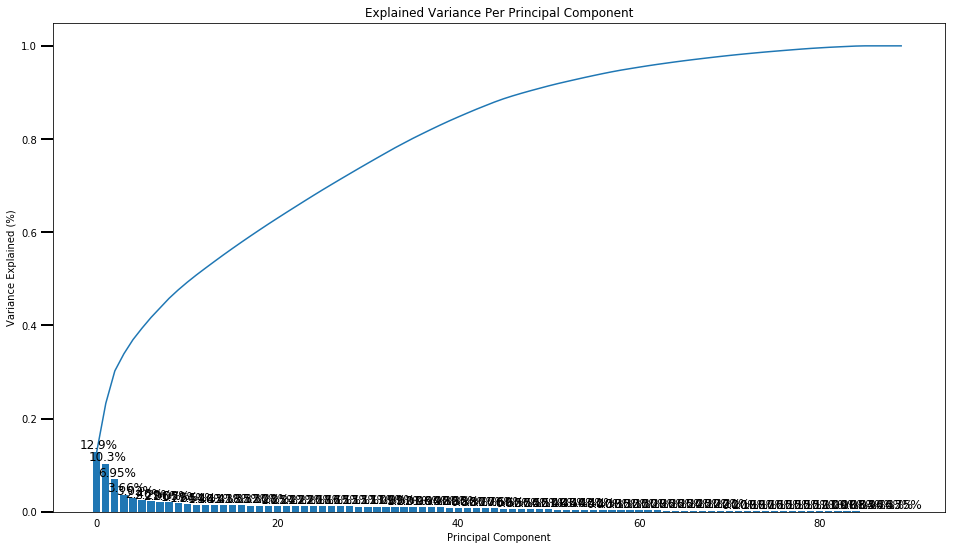

In [109]:
# call scree_plot
scree_plot(pca)

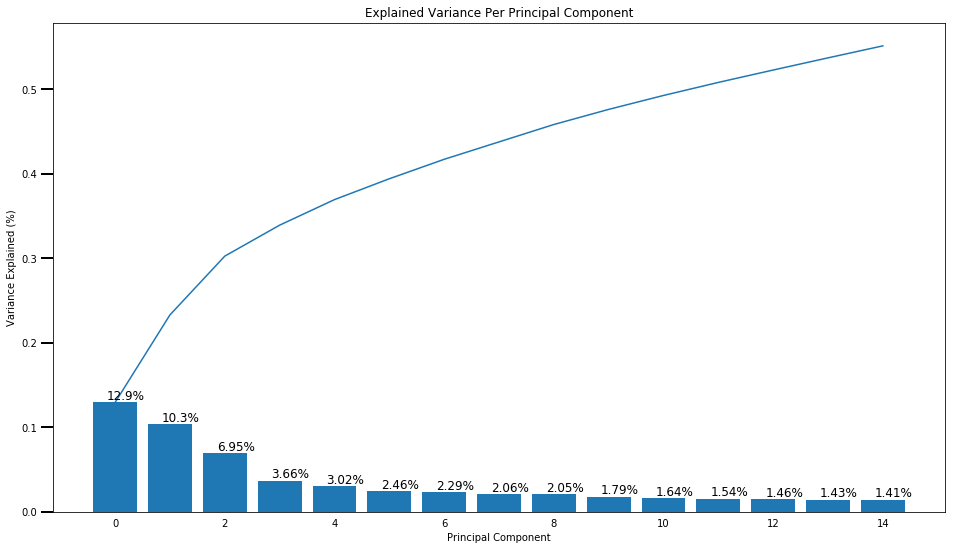

In [110]:
# only show first 15 components to get a detailed view on the most important components
scree_plot(pca, 15) 

In [111]:
# print how much variance can be explained by taking n components into account within PCA
n = 50
for i in range(n+1):
    print('With the first {} components:\t{:.3}% of variance explained'.format(i, pca.explained_variance_ratio_[:i].sum()*100))

With the first 0 components:	0.0% of variance explained
With the first 1 components:	12.9% of variance explained
With the first 2 components:	23.3% of variance explained
With the first 3 components:	30.2% of variance explained
With the first 4 components:	33.9% of variance explained
With the first 5 components:	36.9% of variance explained
With the first 6 components:	39.4% of variance explained
With the first 7 components:	41.7% of variance explained
With the first 8 components:	43.8% of variance explained
With the first 9 components:	45.8% of variance explained
With the first 10 components:	47.6% of variance explained
With the first 11 components:	49.3% of variance explained
With the first 12 components:	50.8% of variance explained
With the first 13 components:	52.3% of variance explained
With the first 14 components:	53.7% of variance explained
With the first 15 components:	55.1% of variance explained
With the first 16 components:	56.5% of variance explained
With the first 17 compone

In [112]:
# Re-apply PCA to the data while selecting for number of components to retain.
n_components = 24
pca_n_comp = PCA(n_components=n_components)
df_pca_n_comp = pca_n_comp.fit_transform(df_scaled)

### Discussion 2.2: Perform Dimensionality Reduction

After performing a Principal Components Analysis (PCA) on the cleaned, encoded and scaled Azdias dataset, we investigated the output pca-object by visualizing scree-plots.
Scree-Plots can depict the explained variance in percentage by the first n major components of the PCA. Additionally, we plotted the percentage adding the explained variance ratio of the first n components to find a threshold for the reduction of dimensionality within the dataset.

We set the threshold to at least 2/3. Thus, we will reduce the number of components to 24. These components can explain 66.7% of the complete variance of the dataset. The effect of adding more components is very minuscule and would only add around one percent of explained variance per additional component.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [113]:
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

# define the pca_results()-function from Udacities "Dimensionality Reduction and PCA" lesson 
# to investigate dimension feature weights and corresponding explained variance
# note: The plotting does not clearly visualize the PCA results. 
#       Therefor, I added an if-condition to switch the visualization on and off
def pca_results(full_dataset, pca, plot_comp = True):
    '''
    Create a DataFrame of the PCA results
    Includes dimension feature weights and explained variance
    Visualizes the PCA results
    '''

    # Dimension indexing
    dimensions = dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions

    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions

    if plot_comp:
        # Create a bar plot visualization
        fig, ax = plt.subplots(figsize = (14,8))

        # Plot the feature weights as a function of the components
        components.plot(ax = ax, kind = 'bar');
        ax.set_ylabel("Feature Weights")
        ax.set_xticklabels(dimensions, rotation=0)


        # Display the explained variance ratios
        for i, ev in enumerate(pca.explained_variance_ratio_):
            ax.text(i-0.40, ax.get_ylim()[1] + 0.05, "Explained Variance\n          %.4f"%(ev))

    # Return a concatenated DataFrame
    return pd.concat([variance_ratios, components], axis = 1)



# define the pca_weights()-function to return the sorted weights of features for a special component of the PCA
def pca_weights(df, pca, comp):
    '''
    create a dictionary of features and sorted weights for a special pca-component
    '''
    weights = {}
    # create an entry in the dictionary for each feature of the dataset (key) and 
    # write the weight as the corresponding value 
    for i, feature in enumerate(df.columns):
        weights[feature] = pca.components_[comp-1][i]
    # sort the weights from top to bottom
    # based on: https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value
    weights_sorted = sorted(weights.items(), key=operator.itemgetter(1), reverse=True)
    return weights_sorted



# define the plot_pca_results()-function to plot the feature weights for a certain dimension
def plot_pca_results(pca_results, pca, dim = 1):
    # get data
    dimension = "Dimension {}".format(dim)
    results = pca_results.drop('Explained Variance', axis=1).loc[dimension].sort_values(ascending=False)
    # split the data into positive and negative results to plot each in different diagrams
    results_pos = results[results>=0]
    results_neg = results[results<0]
    # create 2 subplot and visualize barplots
    plt.figure(figsize=(16,20))
    plt.subplot(211)
    results_pos.plot(kind='bar')
    plt.xlabel('Features (positive weights)', fontsize=14)
    plt.ylabel('Weights', fontsize=14)
    plt.grid(True)
    plt.subplot(212)
    results_neg.plot(kind='bar')
    plt.xlabel('Features (negative weights)', fontsize=14)
    plt.ylabel('Weights', fontsize=14)
    plt.grid(True)
    plt.subplots_adjust(bottom=0.8)
    plt.suptitle('Results of {}'.format(dimension), fontsize=20)
    plt.tight_layout()
    return results

In [114]:
pca.components_[0]

array([-0.1722475 , -0.01092552, -0.22095118,  0.18778248, -0.1586646 ,
        0.1082653 ,  0.11858693,  0.12210987, -0.1028632 ,  0.04641402,
        0.15315661, -0.05616074,  0.05945543,  0.10884197,  0.1549008 ,
        0.11080374, -0.01996659, -0.12342245, -0.12601301,  0.11170779,
        0.12658467, -0.01629289,  0.00955603,  0.01636698,  0.15710971,
        0.14222454, -0.00178248,  0.0155126 , -0.07316769, -0.00616768,
        0.18009677,  0.00885866, -0.07609251,  0.11681625,  0.02575093,
       -0.14202119, -0.02967337, -0.05117528, -0.19763117,  0.00942808,
        0.11888319,  0.13097049, -0.18709575, -0.10627992,  0.16387009,
       -0.13957069, -0.10138319,  0.04015077, -0.21127636, -0.00361238,
        0.06379119, -0.06925916, -0.19342286,  0.12793822,  0.19219855,
        0.1867115 ,  0.03426035, -0.14459796,  0.12205315,  0.16652606,
        0.11161431, -0.01529289,  0.00030027, -0.02489567, -0.00469125,
       -0.03442927, -0.03771943, -0.05803498, -0.00045946,  0.01

In [115]:
# show the results of the pca (explained variance and the weights of the features) for each dimension
df_pca_results = pca_results(df, pca_n_comp, plot_comp = False)
df_pca_results.head(10)

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CJT_GESAMTTYP_advertisinginterested_Store_shopper,CJT_GESAMTTYP_advertisinginterested_Online_shopper,CJT_GESAMTTYP_Advertising_and_Cross_Channel_Enthusiast,CJT_GESAMTTYP_Advertising_Enthusiast_with_restricted_Cross_Channel_Behaviour,NATIONALITAET_KZ_German_sounding,NATIONALITAET_KZ_foreign_sounding,NATIONALITAET_KZ_assimilated_names,MOVEMENT,WEALTH,LIFE_STAGE
Dimension 1,0.1294,-0.1722,-0.0109,-0.2210,0.1878,-0.1587,0.1083,0.1186,0.1221,-0.1029,...,0.0351,0.0427,0.0051,0.0320,-0.0892,0.0735,0.0459,0.1037,0.1781,-0.1204
Dimension 2,0.1035,0.2135,0.0695,0.0112,-0.1876,0.1875,-0.1820,-0.1944,0.1483,-0.0397,...,-0.0262,-0.0538,-0.0347,-0.0370,0.0506,-0.0317,-0.0401,-0.0839,0.1178,-0.0339
Dimension 3,0.0696,0.0613,-0.3709,0.1477,-0.0825,0.0801,-0.1703,-0.0745,-0.0516,0.0435,...,0.0090,0.0037,0.0099,-0.0398,0.0072,0.0207,-0.0411,-0.0590,0.0211,-0.0093
Dimension 4,0.0366,-0.0110,0.0245,0.0772,-0.0208,0.0060,-0.1200,0.0416,-0.1056,0.2966,...,0.0448,-0.0081,0.0368,0.0669,-0.0170,0.0242,-0.0056,-0.1032,-0.0965,0.0516
Dimension 5,0.0302,0.0584,-0.0163,0.0126,-0.0027,-0.0070,0.1155,-0.1032,0.0145,-0.1592,...,-0.0187,-0.0221,0.0808,0.0026,0.0077,-0.0025,-0.0093,0.0442,0.1160,-0.0454
Dimension 6,0.0247,0.0579,-0.0195,-0.0750,0.0065,0.0712,0.0347,-0.0217,0.0664,-0.1399,...,0.0008,-0.0107,0.0761,-0.0396,-0.1055,0.1153,0.0143,0.0402,0.0936,-0.0817
Dimension 7,0.0230,-0.0172,0.0282,-0.0362,0.0023,-0.0337,0.0200,-0.0309,0.0639,0.0202,...,-0.0253,-0.0138,-0.0102,0.0042,0.0421,-0.0554,0.0076,-0.0338,-0.0780,0.0599
Dimension 8,0.0206,-0.0121,-0.0488,0.0995,-0.0133,0.0532,-0.0479,0.0019,-0.2017,-0.0343,...,0.0981,0.0343,-0.0832,-0.0048,-0.3889,0.3649,0.1373,0.0984,-0.0365,-0.0403
Dimension 9,0.0206,-0.0642,0.0733,0.0110,-0.1145,0.1188,-0.0917,-0.0983,0.1481,-0.0095,...,-0.0325,-0.2243,-0.0150,0.0678,-0.4445,0.3402,0.2650,-0.1159,0.0154,0.0372
Dimension 10,0.0179,0.0863,-0.0565,-0.0110,0.0329,-0.0596,-0.0020,-0.0210,-0.0215,-0.0016,...,-0.0137,0.1684,0.0491,-0.1451,-0.2693,0.2306,0.1261,0.0676,0.0119,-0.0259


In [116]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_1 = pca_weights(df,pca_n_comp, comp = 1)
for key, value in weights_1:
    print(key, ' : ', value)

PLZ8_ANTG3  :  0.19219843928834693
FINANZ_SPARER  :  0.18778247251947097
PLZ8_ANTG4  :  0.18671132788879236
HH_EINKOMMEN_SCORE  :  0.18009686698431668
WEALTH  :  0.17813642503986346
ORTSGR_KLS9  :  0.16652610111318678
EWDICHTE  :  0.16387012726238132
SEMIO_PFLICHT  :  0.1571096516447585
SEMIO_REL  :  0.15490079348247981
DECADE  :  0.15315661833406705
SEMIO_TRADV  :  0.14222447677569988
KBA05_ANTG4  :  0.1309707870865992
PLZ8_ANTG2  :  0.12793825523024965
SEMIO_RAT  :  0.12658461487067016
FINANZ_HAUSBAUER  :  0.122110056018412
ARBEIT  :  0.12205361336219489
KBA05_ANTG3  :  0.11888312624892519
FINANZ_UNAUFFAELLIGER  :  0.11858700238767778
ANZ_HAUSHALTE_AKTIV  :  0.11681659728939145
SEMIO_KULT  :  0.11170776720541928
RELAT_AB  :  0.11161496125997022
SEMIO_MAT  :  0.11080378893564105
SEMIO_FAM  :  0.10884194438348765
FINANZ_ANLEGER  :  0.10826528186430182
MOVEMENT  :  0.10368124564754873
GFK_URLAUBERTYP_Without_vacation  :  0.07709870779114282
LP_FAMILIE_GROB_single  :  0.07500295209371725

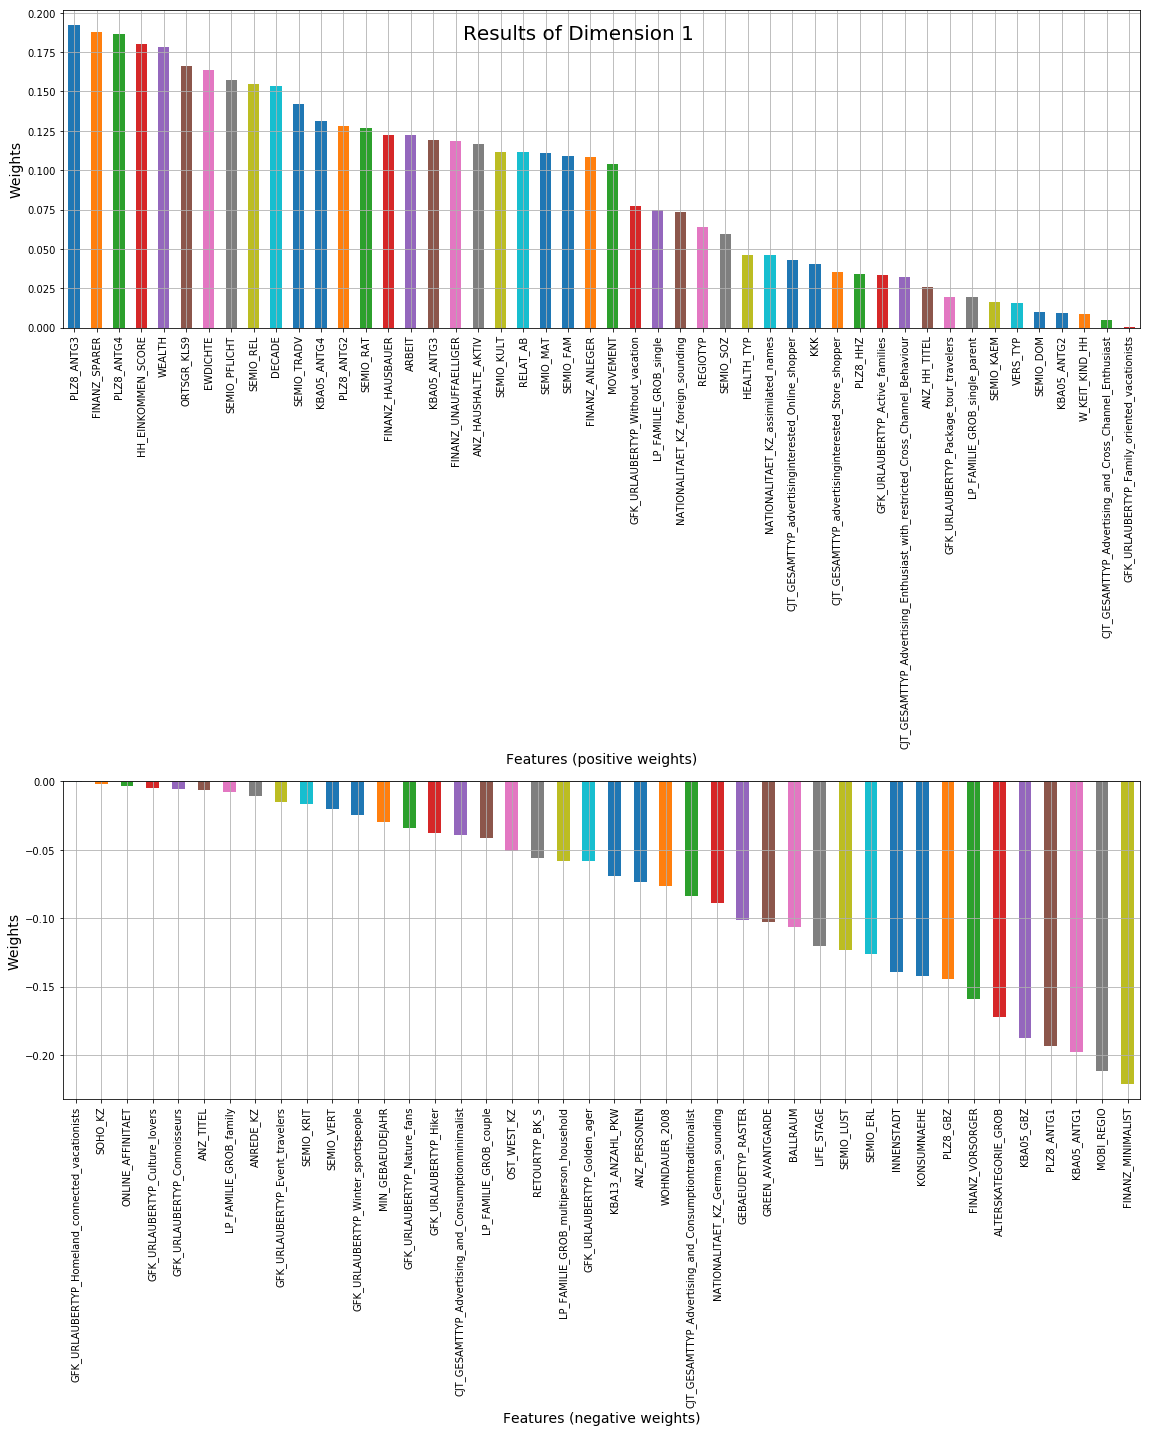

In [117]:
# plot the results for dimension 1  of the pca_results
results_1 = plot_pca_results(df_pca_results, pca_n_comp, 1)

In [118]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_2 = pca_weights(df,pca_n_comp, comp = 2)
for key, value in weights_2:
    print(key, ' : ', value)

ALTERSKATEGORIE_GROB  :  0.2134633342447407
SEMIO_ERL  :  0.18834313166005948
FINANZ_VORSORGER  :  0.1875029485490484
RETOURTYP_BK_S  :  0.15299443168850643
FINANZ_HAUSBAUER  :  0.14829002607938302
SEMIO_LUST  :  0.14778343037265007
PLZ8_ANTG3  :  0.14590988829452298
PLZ8_ANTG4  :  0.13987308072369609
W_KEIT_KIND_HH  :  0.13902198274697183
ORTSGR_KLS9  :  0.13492576154229505
EWDICHTE  :  0.13463022479422693
WEALTH  :  0.11782643984957494
SEMIO_KRIT  :  0.10446007184118258
KBA05_ANTG4  :  0.10110835841382616
ARBEIT  :  0.10067231876796602
SEMIO_KAEM  :  0.09825728642462887
PLZ8_ANTG2  :  0.09719000731582043
CJT_GESAMTTYP_Advertising_and_Consumptiontraditionalist  :  0.09402594752660423
RELAT_AB  :  0.09376416562575439
HH_EINKOMMEN_SCORE  :  0.09208667899079151
ANZ_HAUSHALTE_AKTIV  :  0.09008074526857017
LP_FAMILIE_GROB_single  :  0.08733056715844469
KBA05_ANTG3  :  0.07890282566655762
ANREDE_KZ  :  0.06946991899854955
CJT_GESAMTTYP_Advertising_and_Consumptionminimalist  :  0.06650562456

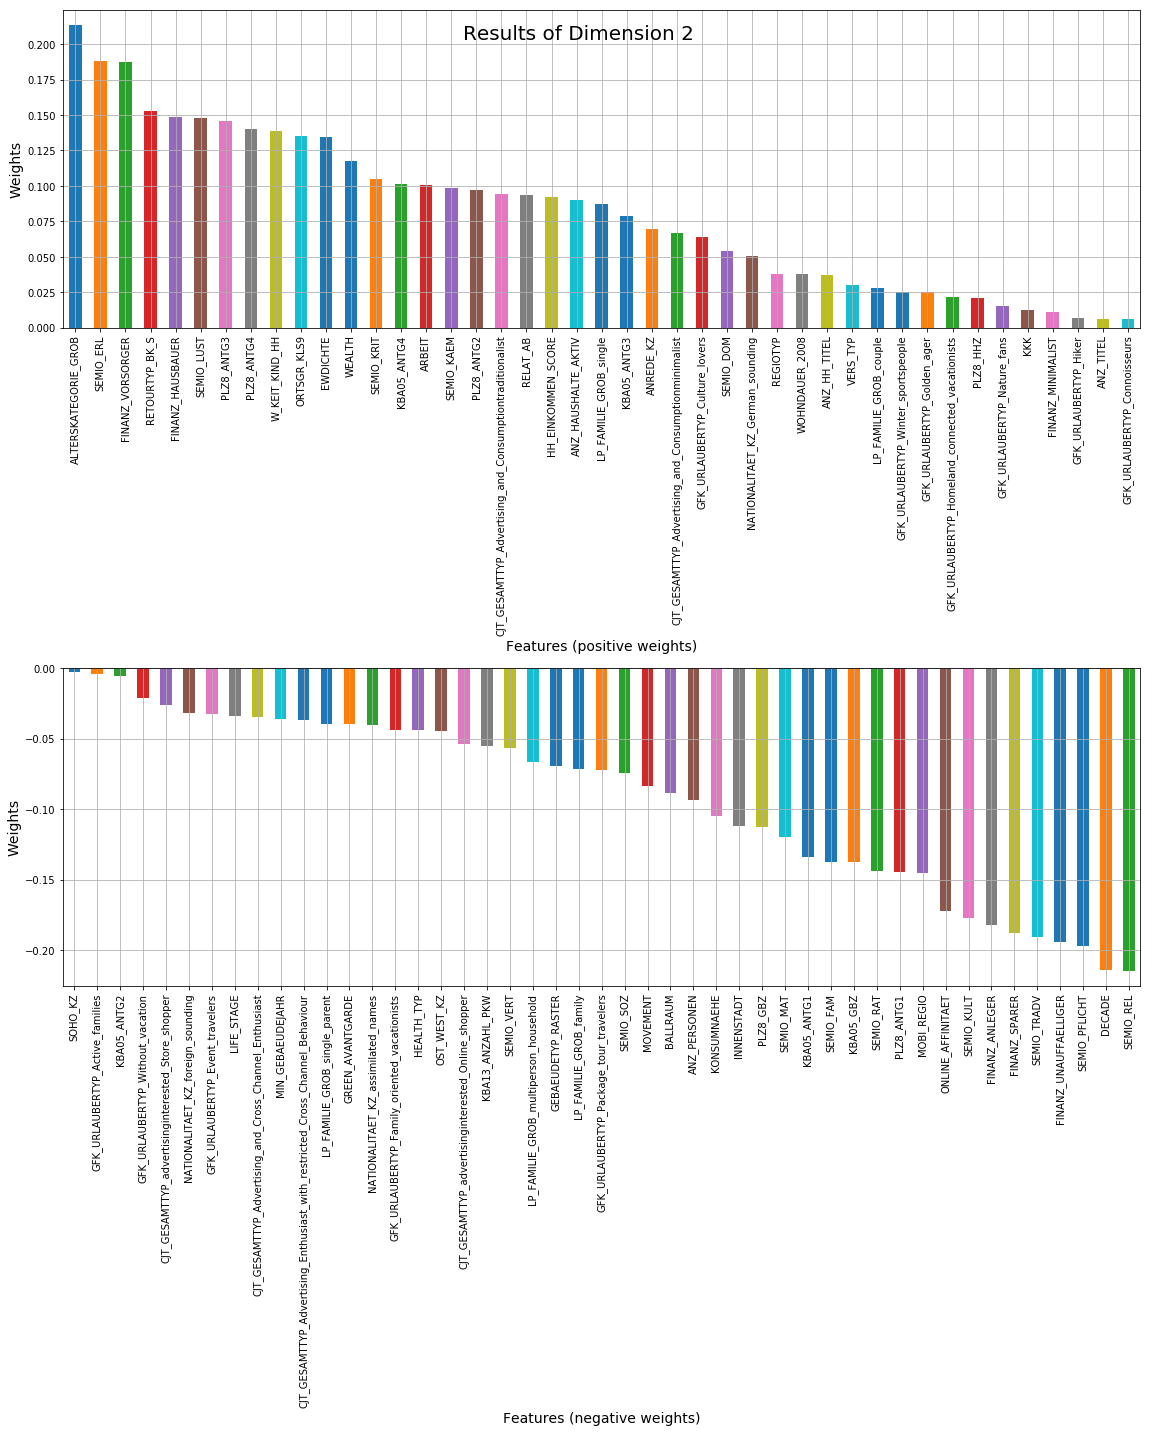

In [119]:
# plot the results for dimension 2  of the pca_results
results_2 = plot_pca_results(df_pca_results, pca_n_comp, 2)

In [120]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_3 = pca_weights(df,pca_n_comp, comp = 3)
for key, value in weights_3:
    print(key, ' : ', value)


SEMIO_VERT  :  0.3492179693490079
SEMIO_SOZ  :  0.26868541513768474
SEMIO_FAM  :  0.2634954097986692
SEMIO_KULT  :  0.24651139171216696
FINANZ_MINIMALIST  :  0.14768062610464983
RETOURTYP_BK_S  :  0.1021467514955572
SEMIO_REL  :  0.0969544064043024
W_KEIT_KIND_HH  :  0.09425428232909926
FINANZ_VORSORGER  :  0.08005663230384877
SEMIO_MAT  :  0.06140330631903869
ALTERSKATEGORIE_GROB  :  0.061316717625797046
SEMIO_LUST  :  0.058294957568378554
GREEN_AVANTGARDE  :  0.04350091459562276
EWDICHTE  :  0.03776949665256668
PLZ8_ANTG4  :  0.037361023261044964
ORTSGR_KLS9  :  0.037283239612006455
GFK_URLAUBERTYP_Culture_lovers  :  0.03703998778804585
PLZ8_ANTG3  :  0.0365850192141159
LP_FAMILIE_GROB_couple  :  0.03126128320465807
CJT_GESAMTTYP_Advertising_and_Consumptionminimalist  :  0.0306890790078246
WOHNDAUER_2008  :  0.02864956583221175
ARBEIT  :  0.02566828721473993
PLZ8_ANTG2  :  0.0244201655926145
RELAT_AB  :  0.02426237412481425
KBA05_ANTG4  :  0.023944532111600636
ANZ_HAUSHALTE_AKTIV  : 

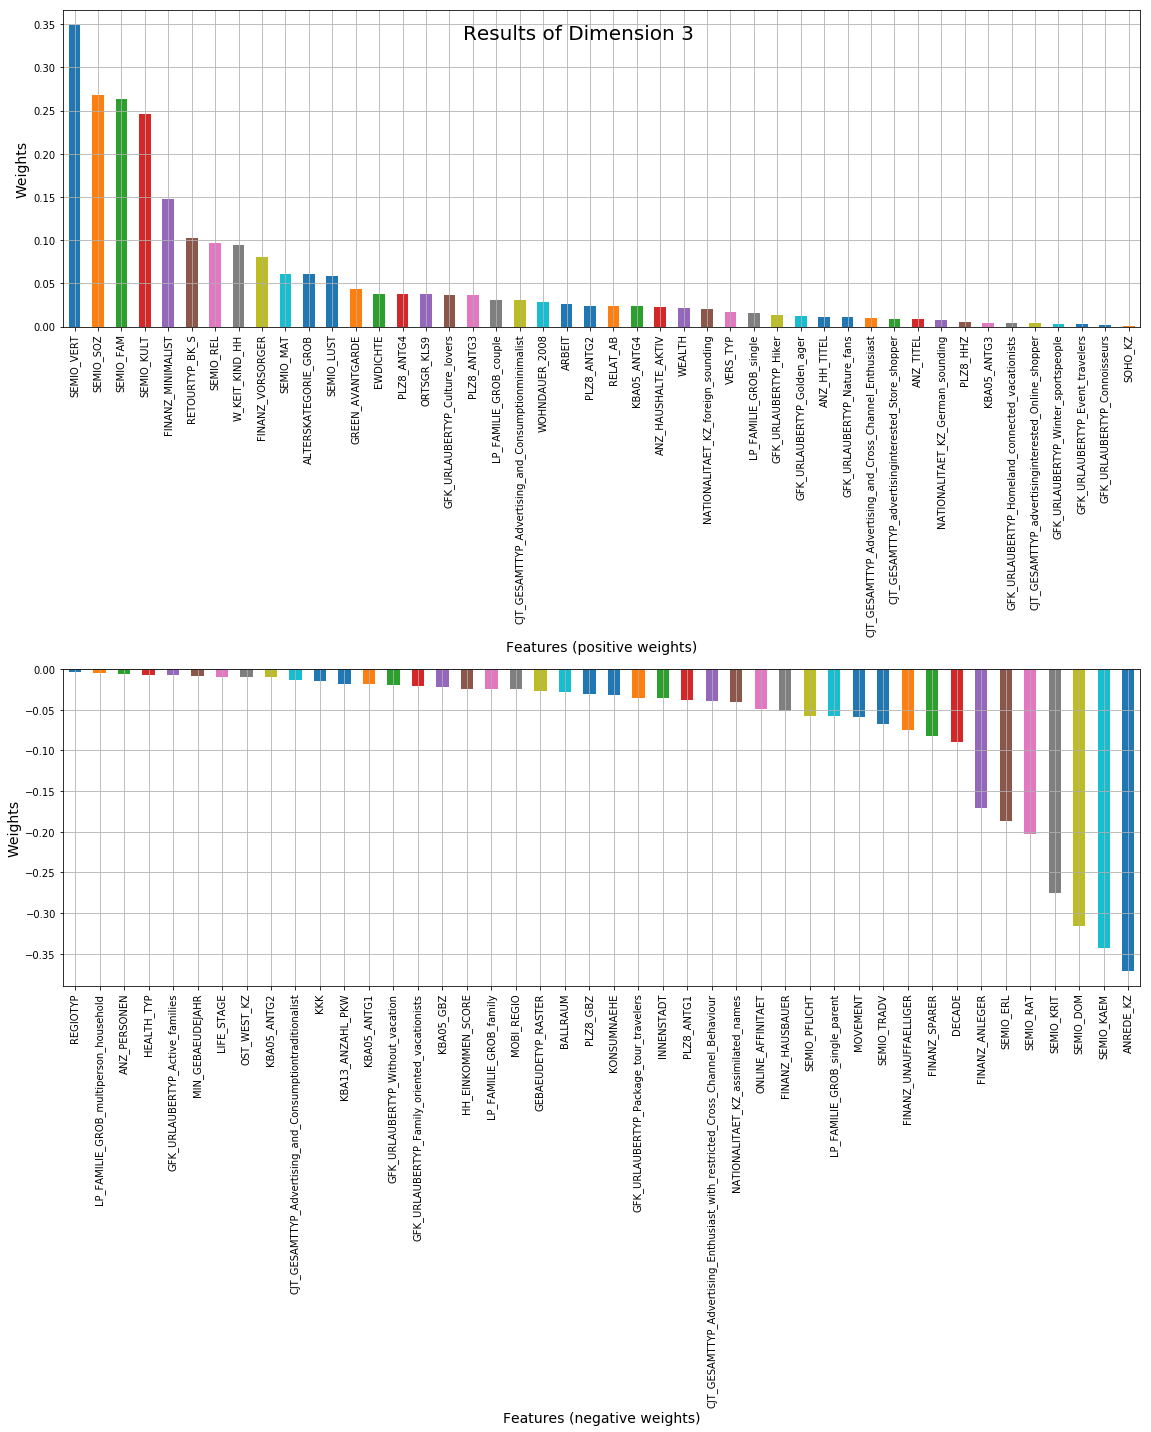

In [121]:
# plot the results for dimension 3  of the pca_results
results_3 = plot_pca_results(df_pca_results, pca_n_comp, 3)

In [122]:
# Map weights for the fourth principal component to corresponding feature names
# and then print the linked values, sorted by weight.
weights_4 = pca_weights(df,pca_n_comp, comp = 4)
for key, value in weights_4:
    print(key, ' : ', value)

GREEN_AVANTGARDE  :  0.2966403575873713
ANZ_PERSONEN  :  0.2872872080436041
EWDICHTE  :  0.2546232055352689
ORTSGR_KLS9  :  0.2458282981163222
LP_FAMILIE_GROB_multiperson_household  :  0.23497840742326767
ONLINE_AFFINITAET  :  0.21656410326011064
LP_FAMILIE_GROB_family  :  0.11116230330384717
PLZ8_ANTG3  :  0.10774950860506231
RELAT_AB  :  0.10632582883802334
PLZ8_ANTG4  :  0.10382443733740826
SEMIO_DOM  :  0.09369978572962051
PLZ8_ANTG2  :  0.08950779806104478
FINANZ_MINIMALIST  :  0.07721069254586561
PLZ8_HHZ  :  0.07612653650634733
SEMIO_KAEM  :  0.07402751472458595
ARBEIT  :  0.07349130699484878
WOHNDAUER_2008  :  0.07193927128187697
OST_WEST_KZ  :  0.06984933158895851
CJT_GESAMTTYP_Advertising_Enthusiast_with_restricted_Cross_Channel_Behaviour  :  0.06690894947752977
KBA05_ANTG1  :  0.06659978673480385
GFK_URLAUBERTYP_Homeland_connected_vacationists  :  0.06361492858125363
GFK_URLAUBERTYP_Connoisseurs  :  0.053338633280089226
LIFE_STAGE  :  0.05161962320034279
GFK_URLAUBERTYP_Pack

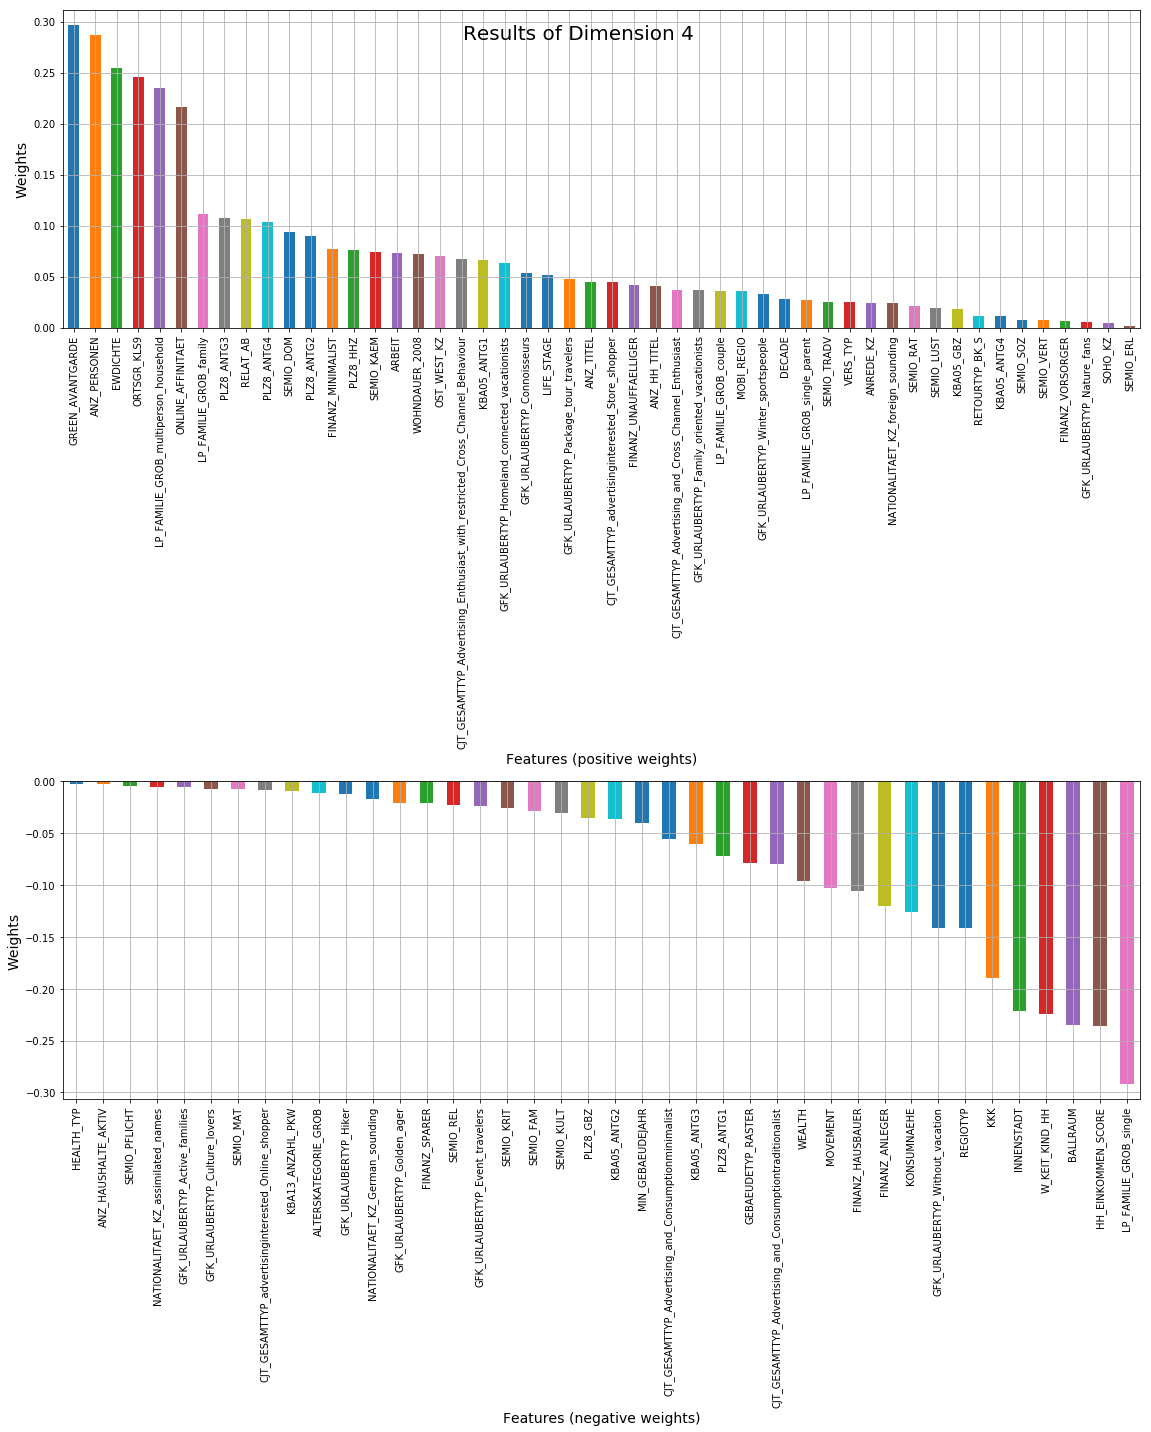

In [123]:
# plot the results for dimension 4  of the pca_results
results_4 = plot_pca_results(df_pca_results, pca_n_comp, 4)

### Discussion 2.3: Interpret Principal Components

We investigated and visualized the PCA-results by implementing different functions:
- pca_results: creates a dataframe containing the explained variance and the correspondng feature weights for each component
- pca_weigths: returns the sorted weights for a certain component
- plot_pca_results: plots the features and sorted weights into 2 barplots (each for positive and negative weights)

We called the functions for the first 4 components to interpret the results. 

Therefor, we list the top 5 positive and negative weights per dimension:

#### Dimension 1 (12.9% of explained variance):
- ##### positive:
    - PLZ8_ANTG3  :  0.1921986429744078 (Number of 6-10 family houses in the PLZ8 region, positive -> high share of family homes) 
    - FINANZ_SPARER  :  0.18778225752418432 (Financial typology, money-saver, positive -> lower)
    - PLZ8_ANTG4  :  0.18671161972190486 (Number of 10+ family houses in the PLZ8 region)
    - HH_EINKOMMEN_SCORE  :  0.1800967576517881 (Estimated household net income, positive -> lower income)
    - WEALTH  :  0.17813641271511974 (Wealth Typology, positive -> poorer)
- ##### negative:
    - KBA05_GBZ  :  -0.18709563251560982 (Number of buildings in the microcell, negative -> less buildings)
    - PLZ8_ANTG1  :  -0.19342290242310817 (Number of 1-2 family houses in the PLZ8 region, negative -> lower share)
    - KBA05_ANTG1  :  -0.19763099813606946 (Number of 1-2 family houses in the microcell, negative -> lower share)
    - MOBI_REGIO  :  -0.2112762281255532 (Movement patterns, negative -> higher movement)
    - FINANZ_MINIMALIST  :  -0.22095110670763643 (Financial typology, low financial interest, negative -> lower financial interests)

The first dimension describes the wealth and living conditions. E.g., that on the one hand the financial situation and the income is designated by features like FINANZ_SPARER; WEALTH, HH_EINKOMMEN_SCORE and FINANZ_MINIMALIST, on the other hand, the area and the kind of buildings of the microcell in which the people are living are described. A positive value in this dimension directs towards poorer living conditions in high populated areas, in which people are dwelling in 6-10 family houses. Negative values direct to financial independence and towards provincial residences with 1-2 family houses. Another aspect is the high movement, which describes commuting as a result of work obligations.  

#### Dimension 2 (10.3% of explained variance):
- ##### positive:
    - ALTERSKATEGORIE_GROB:  0.213463530869 (Estimated age based on given name analysis)
    - SEMIO_ERL:  0.188343497453 (Personality typology, event_oriented)
    - FINANZ_VORSORGER:  0.187502709589 (Financial typology, be prepared)
    - RETOURTYP_BK_S:  0.152994310961 (Return type) 
    - FINANZ_HAUSBAUER:  0.148289248767 (Financial typology, home ownership)
- ##### negative:
    - SEMIO_TRADV:  -0.190880669985 (Personality typology, traditional-minded)
    - FINANZ_UNAUFFAELLIGER:  -0.194402003656 (Financial typology, inconspicious)
    - SEMIO_PFLICHT:  -0.197040335492 (Personality typology, dutiful)
    - DECADE:  -0.214237127871 (Dominating decade of person's youth)
    - SEMIO_REL:  -0.214453106422 (Personality typology, religious)

It seems that features containing information about the financial typology (FINANZ_VORSORGER, FINANZ_UNAUFFAELLIGER), the age (ALTERSKATEGORIE_GROB, DECADE) as well as the personality concerning e.g. religious aspects of the population are mapped by the PCA Dimension 1. ALTERSKATEGORIE_GROB and DECADE have highly rated opposite weights, which is comprehensible, since high values in ALTERSKATEGORIE_GROB indicate elderly people, which correspond to low values in DECADE (derived from PRAEGENDE_JUGENDJAHRE). Other opposing features are RETOURTYP_BK_S, indicating a conservative and determined shopper, and SEMIO_PFLICHT, indicating the dutifulness of a person.

As a result, dimension 1 designates elderly, traditional/religious and dutiful people.

#### Dimension 3 (7% of explained variance):
- ##### positive:
    - SEMIO_VERT  :  0.349215301093 (Personality typology, dreamful)
    - SEMIO_SOZ  :  0.268683567957 (Personality typology, socially-minded)
    - SEMIO_FAM  :  0.263496518456 (Personality typology, family-minded)
    - SEMIO_KULT  :  0.246511988544 (Personality typology, cultural-minded)
    - FINANZ_MINIMALIST  :  0.14768230723 (Financial typology, low financial interest)
- ##### negative:
    - SEMIO_RAT  :  -0.202816814106 (Personality typology, rational)
    - SEMIO_KRIT  :  -0.274916194386 (Personality typology, critical-minded)
    - SEMIO_DOM  :  -0.316048185118 (Personality typology, dominant-minded)
    - SEMIO_KAEM  :  -0.342993768004 (Personality typology, combative attitude)
    - ANREDE_KZ  :  -0.370865793199 (Gender, 1 - male, 2 - female)
    
Dimension 3 is dominated by features concerning the personality typology (SEMIO_XXX). The positive weights are indicating a low affinity towards cultural or social aspects as well as a low financial interest. On the other hand, a high affinity towards rational and critical thinking as well as a high combative attitude is described by large negative weights. Here, the highest absolute values is indicating the gender.

As a result, dimension 3 designates a rational (opposite of dreamful) and dominant male person with a low affinity towards family or sociocultural aspects.

#### Dimension 4 (3.7% of explained variance):
- ##### positive:
    - GREEN_AVANTGARDE  :  0.296608564421 (Membership in environmental sustainability as part of youth)
    - ANZ_PERSONEN  :  0.287089455604 (Number of adults in household)
    - EWDICHTE  :  0.254687342569 (Density of households per square kilometer)
    - ORTSGR_KLS9  :  0.245902912002 (Size of community)
    - LP_FAMILIE_GROB_multiperson_household  :  0.234581317551 (Family type, multiperson household)
- ##### negative:
    - INNENSTADT  :  -0.221693280286 (Distance to city center)
    - W_KEIT_KIND_HH  :  -0.224142092647 (Likelihood of children in household, negative -> likely)
    - BALLRAUM  :  -0.234995838395 (Distance to nearest urban center)
    - HH_EINKOMMEN_SCORE  :  -0.235477584271 (Estimated household net income, negative -> high income)
    - LP_FAMILIE_GROB_single  :  -0.291827094318 (Family type, single)
    
The features of dimension 4 map astonishingly well onto the segment family and residential area. Here, we have a lot of features concerning the type of family or household, the person lives in. Also opposing features are weighted with different signs (e.g. ANZ_PERSONEN and LP_FAMILIE_GROB_multiperson_household vs. LP_FAMILIE_GROB_single and W_KEIT_KIND_HH).

As a result, dimension 4 designates a multiperson household (family or residential community) in large cities or city centers. We can also see, that there's is a high affinity towards environmental sustainability in this group of people.

#### Results:
For the first four dimensions, we can summarize the indicated segments as follows. Therefor, the columns "positive" and "negative" indicate characteristics that are corresponding to high positive or negative values within this dimension.

| Dimension | Segment                 | Positive                                  | Negative                                |
|-----------|-------------------------|-------------------------------------------|-----------------------------------------|
| 1         | Wealth and Neighborhood | poor; multi-family houses;<br> low income | single-family houses; financial independent; <br> employed|
| 2         | Traditional Adults      | elderly; traditional;<br> religious       | young; adventurous;                     |
| 3         | Personal Type           | female; sociocultural;<br> family-minded  | male; rational; critical;<br> dominant  |
| 4         | Family and Residence    | ecological; community;<br> city residence | single or family (children);<br> provincial; high income | 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [124]:
# Over a number of different cluster counts...
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)

# run k-means clustering on the data and...
model_kmeans = kmeans.fit(df_pca_n_comp)

# compute the average within-cluster distances.
model_kmeans.score(df_pca_n_comp)

-22645277.43979446

We investigated the kmeans.score of a cluster count of 10, which gives us a relatively large negative number. To classify and assess this value, we apply different cluster counts on the same dataset. Therefor, we implement the get_kmeans_score()-function based on Udacitys Clustering lesson.

In [125]:
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = KMeans(n_clusters=center)

    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))
    
    return score

In [126]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
scores = []
centers = list(range(1,31))

for center in centers:
    print('Clustering with k = {}...'.format(center))
    score = get_kmeans_score(df_pca_n_comp, center)
    scores.append(score)
    print('Score: {}'.format(score))

Clustering with k = 1...
Score: 37278742.22302154
Clustering with k = 2...
Score: 32003354.856475834
Clustering with k = 3...
Score: 28945039.328011967
Clustering with k = 4...
Score: 27263871.65839323
Clustering with k = 5...
Score: 26083917.674462467
Clustering with k = 6...
Score: 25011843.786989387
Clustering with k = 7...
Score: 24139507.11347073
Clustering with k = 8...
Score: 23426853.704507668
Clustering with k = 9...
Score: 23020544.038865883
Clustering with k = 10...
Score: 22645276.769197367
Clustering with k = 11...
Score: 22299632.761675898
Clustering with k = 12...
Score: 21978041.43763545
Clustering with k = 13...
Score: 21621785.68079044
Clustering with k = 14...
Score: 21376172.39256869
Clustering with k = 15...
Score: 21127417.70002392
Clustering with k = 16...
Score: 20883525.46279965
Clustering with k = 17...
Score: 20738211.359244086
Clustering with k = 18...
Score: 20451930.44106833
Clustering with k = 19...
Score: 20193400.798389073
Clustering with k = 20...
Scor

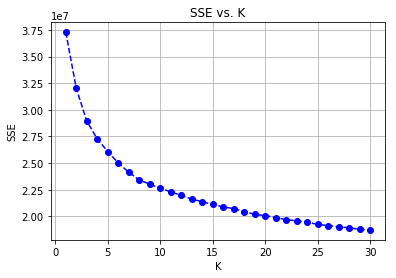

In [127]:
# Plot scores (elbow plot)
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
plt.grid(True)

In [128]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters)
model_kmeans = kmeans.fit(df_pca_n_comp)

### Discussion 3.1: Apply Clustering to General Population

To investigate the right number of clusters or centers in our dataset, we calculated the sum of squared errors (SSE) of the data points, which equals the distances between the points and the centers. With this information, we can create an "elbow plot" (number of centers vs. SSE). The aim is to identify the k (or the elbow within the plot) after which the SSE only little improves with an increasing number of clusters.

Unfortunately, we cannot ambigously specify this point in our elbow plot, so I decided to apply 10 clusters to our dataset.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [5]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.shape

(191652, 85)

In [7]:
# Clean data via clean_data()-function
customers_clean = customers.copy()
customers_clean = clean_data(customers_clean)
customers_clean.isnull().sum().sum()

0

In [131]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
standard_scaler = StandardScaler()
customers_scaled = standard_scaler.fit_transform(customers_clean)
customers_pca = pca_n_comp.fit_transform(customers_scaled)

C:\Users\Kroening\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Kroening\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [132]:
# create predictions applying the model_kmeans on customer data
customers_pred = model_kmeans.predict(customers_pca)

# ... and general data
general_pred = model_kmeans.predict(df_pca_n_comp)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [133]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

# convert predictions into dataframe to use pandas functions for exploration
general_pred = pd.DataFrame(general_pred, columns=['General_predictions'])
customers_pred = pd.DataFrame(customers_pred, columns=['Customers_predictions'])

# count values for each column of the created dataset
general_pred_sort = general_pred.General_predictions.value_counts().sort_index()
customers_pred_sort = customers_pred.Customers_predictions.value_counts().sort_index()
print("Counted Values")
print("Value:\t General Predictions:\t Customers Predictions:")
for i in range(len(general_pred_sort)):
    print(i,'\t', general_pred_sort[i],'\t\t\t',customers_pred_sort[i])

Counted Values
Value:	 General Predictions:	 Customers Predictions:
0 	 80406 			 9565
1 	 62346 			 11088
2 	 57708 			 12635
3 	 60244 			 25034
4 	 64044 			 10114
5 	 57036 			 12572
6 	 57627 			 9576
7 	 55785 			 6993
8 	 45393 			 8567
9 	 82622 			 9499


In [134]:
# calculate the proportions for each value in both dataframes

general_pred_prop = general_pred_sort/len(general_pred)
customers_pred_prop = customers_pred_sort/len(customers_pred)

# print the results
print("Proportions")
print("Value:\t General Predictions:\t Customers Predictions:")
for i in range(len(general_pred_prop)):
    print("{} \t {:.2f}%\t\t\t {:.2f}%".format(i,general_pred_prop[i]*100,customers_pred_prop[i]*100))

Proportions
Value:	 General Predictions:	 Customers Predictions:
0 	 12.90%			 8.27%
1 	 10.00%			 9.59%
2 	 9.26%			 10.93%
3 	 9.67%			 21.65%
4 	 10.28%			 8.75%
5 	 9.15%			 10.87%
6 	 9.25%			 8.28%
7 	 8.95%			 6.05%
8 	 7.28%			 7.41%
9 	 13.26%			 8.21%


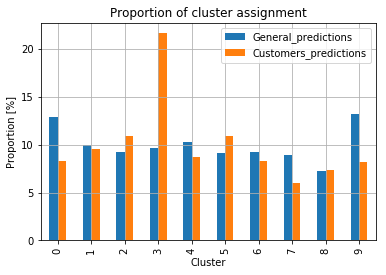

In [135]:
# plot the results
df_prop = pd.concat([general_pred_prop*100, customers_pred_prop*100], axis=1)
df_prop.plot(y = ["General_predictions","Customers_predictions"], kind="bar")
plt.xlabel("Cluster")
plt.ylabel("Proportion [%]")
plt.grid(True)
plt.title("Proportion of cluster assignment");

In [136]:
df_prop['prop_diff'] = df_prop.General_predictions - df_prop.Customers_predictions
df_prop

,General_predictions,Customers_predictions,prop_diff
0,12.901890,8.271145,4.630746
1,10.003995,9.588129,0.415866
2,9.259785,10.925867,-1.666081
3,9.666710,21.647657,-11.980947
4,10.276455,8.745882,1.530574
5,9.151957,10.871389,-1.719432
6,9.246788,8.280657,0.966131
7,8.951222,6.047059,2.904163
8,7.283729,7.408144,-0.124415
9,13.257468,8.214073,5.043396


Clusters where customers are proportionally overrepresented (negative prop_diff):
- 2
- 3 (maximum customers proportion and largest negative difference between general and customers prediction proportion)
- 5
- 8

Clusters where customers are proportionally underrepresented:
- 0
- 1 
- 4
- 6 
- 7 (minimum customers proportion)
- 9 (largest positive difference between general and customers prediction proportion)

In [137]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

# combine customers_pca with predictions into dataframe
customers_pca_pred = pd.merge(left=pd.DataFrame(customers_pca), right=customers_pred, left_index=True, right_index=True)
customers_pca_pred.head(10)

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,Customers_predictions
0,-3.694607,-2.358598,-2.447713,-0.244630,-1.827697,2.762114,-1.871045,0.061061,-0.748572,0.666202,...,0.261879,0.456763,0.452089,-2.080115,0.946637,0.412488,1.323903,-0.451166,0.420479,3
1,3.634422,-3.105274,1.947458,1.575113,-0.720044,-1.351148,-1.105978,-0.172477,-0.333860,0.349993,...,0.125939,0.011812,-0.057467,-1.332938,-1.213637,-0.910154,-0.299194,-0.108501,-1.113710,5
2,2.255440,5.542021,-0.185818,-1.339185,2.099842,0.470529,0.209476,-1.162543,-1.697315,-0.365805,...,2.112909,1.253157,-1.287401,-1.731742,-1.792860,1.866552,1.478380,1.139317,-1.503212,9
3,-0.024394,0.542246,-1.711194,1.373634,-1.889064,0.699547,0.911435,-2.655974,0.544752,-0.773742,...,-1.574031,-0.784959,1.861992,1.084545,0.155337,-2.116622,1.593313,-0.180765,-1.205270,3
4,-3.674997,-1.733659,-0.772807,-0.478251,-2.197767,1.361638,0.135529,-0.950743,0.605313,-0.131689,...,-0.447031,1.090110,-0.814917,1.330152,-0.078898,0.089862,0.084242,0.210613,-0.026207,3
5,-2.499047,-2.203211,-3.119248,1.024628,-1.126247,-0.436753,-1.529428,1.627877,-1.151614,0.325754,...,-0.416311,-1.070380,-1.345367,-1.462765,-0.194061,-1.020746,-0.458671,0.124992,0.926578,3
6,-2.946674,3.446253,0.347682,1.642409,0.489725,0.504041,-0.737539,-2.766501,1.794167,-0.487073,...,-0.531593,-0.922351,-1.486576,0.173229,0.500947,-0.834261,1.218386,-0.485024,-1.385217,6
7,-3.456768,0.065599,-2.286968,-0.066365,-2.801080,0.204237,-2.219547,2.738491,-0.409456,-0.073185,...,-0.023665,-0.530464,0.116821,0.197375,3.861983,0.843721,-0.316718,1.344250,0.798932,6
8,-4.751445,1.564056,1.552920,-3.346789,0.454143,1.499269,-1.892870,-0.695272,0.939593,0.359428,...,-0.774593,2.206323,0.508857,-0.218785,-0.772957,0.063416,0.349528,0.492389,0.253250,4
9,7.688269,-2.583286,0.435544,-0.095940,-0.274649,0.361514,0.163142,-1.880077,-0.503439,0.105589,...,-0.738624,1.128302,-1.069605,1.191690,-0.952035,0.389231,0.031390,0.621452,-0.376876,5


In [141]:
# retransform PCA to obtain the feature weights for overrepresented clusters
# clusters: 2,3,5,8
overrepresented_2 = pd.DataFrame(
    standard_scaler.inverse_transform(
    pca_n_comp.inverse_transform(customers_pca_pred.query('Customers_predictions == 2').drop('Customers_predictions', axis=1))),
    columns=customers_clean.columns)

overrepresented_3 = pd.DataFrame(
    standard_scaler.inverse_transform(
    pca_n_comp.inverse_transform(customers_pca_pred.query('Customers_predictions == 3').drop('Customers_predictions', axis=1))),
    columns=customers_clean.columns)

overrepresented_5 = pd.DataFrame(
    standard_scaler.inverse_transform(
    pca_n_comp.inverse_transform(customers_pca_pred.query('Customers_predictions == 5').drop('Customers_predictions', axis=1))),
    columns=customers_clean.columns)

overrepresented_8 = pd.DataFrame(
    standard_scaler.inverse_transform(
    pca_n_comp.inverse_transform(customers_pca_pred.query('Customers_predictions == 8').drop('Customers_predictions', axis=1))),
    columns=customers_clean.columns)

# calculate the mean for each feature and store in dataframe
overrepresented_df = pd.DataFrame([overrepresented_2.mean(),overrepresented_3.mean(),
                                   overrepresented_5.mean(),overrepresented_8.mean()]).transpose()
overrepresented_df.rename(columns = {0 : 'Mean_prediction_2', 1 : 'Mean_prediction_3',
                                     2 : 'Mean_prediction_5', 3 : 'Mean_prediction_8'})

,Mean_prediction_2,Mean_prediction_3,Mean_prediction_5,Mean_prediction_8
ALTERSKATEGORIE_GROB,3.920764,3.821819,3.711257,3.933453
ANREDE_KZ,1.363484,0.986312,1.983944,1.931918
FINANZ_MINIMALIST,4.762688,4.964003,2.999124,4.361921
FINANZ_SPARER,1.057533,1.059146,1.292774,0.950685
FINANZ_VORSORGER,4.916079,4.905911,4.766578,5.019439
FINANZ_ANLEGER,1.583240,0.992448,1.578760,1.444792
FINANZ_UNAUFFAELLIGER,1.483800,1.652054,1.517205,1.526437
FINANZ_HAUSBAUER,2.501062,2.304293,4.518094,3.050384
GREEN_AVANTGARDE,0.420677,0.856707,0.231853,0.617357
HEALTH_TYP,1.716353,1.543786,1.924744,1.813211


In [143]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

# retransform PCA to obtain the feature weights for underrepresented clusters
# clusters: 0, 1, 4, 6, 7, 9
underrepresented_0 = pd.DataFrame(
    standard_scaler.inverse_transform(
    pca_n_comp.inverse_transform(customers_pca_pred.query('Customers_predictions == 0').drop('Customers_predictions', axis=1))),
    columns=customers_clean.columns)

underrepresented_1 = pd.DataFrame(
    standard_scaler.inverse_transform(
    pca_n_comp.inverse_transform(customers_pca_pred.query('Customers_predictions == 1').drop('Customers_predictions', axis=1))),
    columns=customers_clean.columns)

underrepresented_4 = pd.DataFrame(
    standard_scaler.inverse_transform(
    pca_n_comp.inverse_transform(customers_pca_pred.query('Customers_predictions == 4').drop('Customers_predictions', axis=1))),
    columns=customers_clean.columns)

underrepresented_6 = pd.DataFrame(
    standard_scaler.inverse_transform(
    pca_n_comp.inverse_transform(customers_pca_pred.query('Customers_predictions == 6').drop('Customers_predictions', axis=1))),
    columns=customers_clean.columns)

underrepresented_7 = pd.DataFrame(
    standard_scaler.inverse_transform(
    pca_n_comp.inverse_transform(customers_pca_pred.query('Customers_predictions == 7').drop('Customers_predictions', axis=1))),
    columns=customers_clean.columns)

underrepresented_9 = pd.DataFrame(
    standard_scaler.inverse_transform(
    pca_n_comp.inverse_transform(customers_pca_pred.query('Customers_predictions == 9').drop('Customers_predictions', axis=1))),
    columns=customers_clean.columns)

# calculate the mean for each feature and store in dataframe
underrepresented_df = pd.DataFrame([underrepresented_0.mean(), underrepresented_1.mean(), underrepresented_4.mean(),
                                    underrepresented_6.mean(), underrepresented_7.mean(), underrepresented_9.mean()]).transpose()
underrepresented_df.rename(columns = {0 : 'Mean_prediction_0', 1 : 'Mean_prediction_1', 2 : 'Mean_prediction_4',
                                      3 : 'Mean_prediction_6', 4 : 'Mean_prediction_7', 5 : 'Mean_prediction_9'})

,Mean_prediction_0,Mean_prediction_1,Mean_prediction_4,Mean_prediction_6,Mean_prediction_7,Mean_prediction_9
ALTERSKATEGORIE_GROB,2.773752,3.609485,3.302111,2.985863,3.949184,2.778419
ANREDE_KZ,1.857875,1.091972,1.323191,0.989942,1.021081,1.026946
FINANZ_MINIMALIST,3.476461,3.404039,4.782607,4.923064,4.691992,3.864515
FINANZ_SPARER,2.535242,1.233709,1.493863,1.620058,0.961049,2.301080
FINANZ_VORSORGER,3.440098,4.826657,4.493885,4.343385,5.015229,3.699589
FINANZ_ANLEGER,2.953969,1.039677,1.981843,1.679921,0.925017,2.101751
FINANZ_UNAUFFAELLIGER,2.714452,1.435337,1.874422,2.061648,1.525992,2.539649
FINANZ_HAUSBAUER,2.530846,4.187238,1.891132,1.646314,2.797219,2.422434
GREEN_AVANTGARDE,0.440447,0.222367,0.451688,0.634468,0.604964,0.522178
HEALTH_TYP,2.296045,1.915202,2.411384,2.448009,1.705141,2.416857


In [144]:
# create a DataFrame for comparison of the mean feature values of all overrepresented and underrepresented clusters 
# as well as the clusters which show the largest difference between the general and the customer prediction proportions
# in this case, we also included the mean of cluster 3 (maximum customer proportion) 
# and cluster 9 (largest positive difference between general and customer prediction proportions)
df_compare = pd.DataFrame([overrepresented_df.mean(axis=1),underrepresented_df.mean(axis=1),
                           overrepresented_3.mean(),underrepresented_9.mean()]).transpose()
df_compare.rename(columns={0:'Mean_overrepresented', 1:'Mean_underrepresented', 2:'Mean_3_max_over', 3:'Mean_9_max_under'})

,Mean_overrepresented,Mean_underrepresented,Mean_3_max_over,Mean_9_max_under
ALTERSKATEGORIE_GROB,3.846823,3.233136,3.821819,2.778419
ANREDE_KZ,1.566414,1.218501,0.986312,1.026946
FINANZ_MINIMALIST,4.271934,4.190446,4.964003,3.864515
FINANZ_SPARER,1.090035,1.690833,1.059146,2.301080
FINANZ_VORSORGER,4.902002,4.303141,4.905911,3.699589
FINANZ_ANLEGER,1.399810,1.780363,0.992448,2.101751
FINANZ_UNAUFFAELLIGER,1.544874,2.025250,1.652054,2.539649
FINANZ_HAUSBAUER,3.093458,2.579197,2.304293,2.422434
GREEN_AVANTGARDE,0.531648,0.479352,0.856707,0.522178
HEALTH_TYP,1.749524,2.198773,1.543786,2.416857


### Discussion 3.3: Compare Customer Data to Demographics Data

To investigate the general and customers datasets, we performed following steps:
- create predictions for the general and the customers data using the KMeans model
- count the observations grouped by the predicted cluster (0 - 9) for each dataset
- calculate the proportion of each predicted cluster within each dataset
- compare the proportions between the general and the customers dataset
- identify clusters in which the customers are overrepresented
- identify clusters in which the customers are underrepresented
- calculate the mean values of the features within the clusters to find characteristics

The comparison between the proportion of predicted values of the customers dataset and the general datasets visualized some interesting aspects. First, cluster 3 displayed a very large overrepresentation of customers. Around 21.6% of the customers are part of this group, but only 9.7% of the general population can be classified by this cluster. Thus, we identified a huge mismatch between the group of customers and the population, which has to be explored with regard to feature characteristics in the following steps. Additionally, clusters 2, 5 and 8 exhibited a slight overrepresentation. Clusters in which the customers are proportionally underrepresented are number 0, 1, 4, 6, 7, 9 - especially in clusters 0 and 9 a difference of around 5% between the population and the customers was explored.

After the identification of clusters showing overrepresentation and underrepresentation of customers, we observed the corresponding mean of feature values within each predicted cluster. Additionally, we calculated the mean of all overrepresented and of all underrepresented clusters to explore differences between these groups. However, the focus of the feature exploration is on cluster 3 and 9, which showed the largest differences between the population and customers predictions. 

A conspicuous difference of these clusters can be observed in the age of the customers. The average age in overrepresentation of cluster 3 is much higher (DECADE = 1953 vs. DECADE = 1971, ALTERSKATEGORIE_GROB = 3.82 vs. 2.78) than in the underrepresented cluster 9. Thus, customers might primarly be elderly people. The group in which customers are more overrepresented also usually live in a conservative or upper class neighborhood, whereas the underrepresented cluster is primarly domiciled in middle or lower middle class neighborhoods (feature REGIOTYP). Other characteristcs are shown in the dataframe table above.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.